## pNN Plots

In [2]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from script import utils, cms
from script.utils import free_mem
from script.models.layers import Clip, Divide, StandardScaler

from script.datasets import Dataset

from scipy.stats import pearsonr

sns.set()

In [3]:
# for debugging, comment if not needed
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload

In [4]:
utils.set_random_seed(42)

Random seed 42 set.


In [5]:
INTERVALS = [(115, 180),   # 130
             (115, 200),   # 150
             (120, 220),   # 170
             (150, 250),   # 200
             (200, 300),   # 250
             (225, 375),   # 300
             (275, 425),   # 350
             (300, 500),   # 400
             (350, 550),   # 450
             (350, 650),   # 500
             (400, 800),   # 600
             (500, 900),   # 700
             (600, 1000),  # 800
             (700, 1800),  # 1000
             (700, 1800),  # 1200
             (700, 1800)]  # 1500

In [6]:
def plot_var(dataset: Dataset, variable: str, title: str, mass: list, bins=50, size=(12, 10),
             limit=None):
    plt.figure(figsize=size)
    
    var_range = (dataset.ds[variable].min(), dataset.ds[variable].max())
    
    if isinstance(limit, (int, float)):
        a, b = var_range
        var_range = (a, min(b, limit))
    
    w_s = 0.0
    w_b = np.sum(dataset.background['weight'])

    plt.hist(dataset.background[variable], bins=bins, label='bkg', alpha=0.25, color='blue',
             range=var_range, weights=dataset.background['weight'])

    for m in reversed(mass):
        s = data.signal[data.signal['mA'] == m][variable]
        w_s += len(s)
    
    w_s = w_b / w_s

    for m in reversed(mass):
        s = dataset.signal[dataset.signal['mA'] == m][variable]

        plt.hist(s, bins=bins, label=f'{int(m)}mA', alpha=1.0, hatch='//',
                 histtype='step', linewidth=2, range=var_range, 
                 weights=np.ones((s.shape[0],)) * w_s)

    plt.title(f'{title} [{bins} bins]')
    plt.xlabel(variable)
    plt.ylabel(f'Weighted Count (Events / {bins} GeV)')

    plt.legend(loc='best')
    plt.show()
    free_mem()


In [7]:
def plot_corr(dataset: Dataset, colors=None, size=(12, 10), digits=3, 
              legend='best', title='', variables=None, target='dimuon_mass',):
    if variables is None:
        variables = dataset.columns['feature']
        
    variables = sorted(variables)
    
    if colors is None:
        colors = cms.plot.PALETTE
    
    sig = dataset.signal
    bkg = dataset.background

    data = {'signal': sig}
    data.update({k: bkg[bkg['name'] == k] for k in bkg['name'].unique()})
    
    u = {k: [] for k in data.keys()}
    
    # compute correlation
    for key, df in data.items():
        target_var = df[target].values
        
        for var in variables:
            values = df[var].values
            u[key].append(pearsonr(values, target_var)[0])
    
    # plot
    fig = plt.figure(figsize=size)
    
    for k in data.keys():
        avg = np.mean(u[k]).item()
        plt.plot(variables, u[k], marker='o', color=colors[k], label=f'{k}: {round(avg, digits)}',
                 linestyle='dashed' if k != 'signal' else 'solid')
    
    plt.xticks(rotation='vertical')
    
    plt.ylabel(f'Pearson Corr. vs {target}')
    plt.title(f'Pearson Correlation: {title}')
        
    plt.legend(loc=str(legend))
    plt.show()


## Category-1

In [6]:
VAR_CAT1 = ["dimuon_deltar", "dimuon_deltaphi", "dimuon_deltaeta", "met_pt", 
             "deltar_bjet1_dimuon", "deltapt_bjet1_dimuon", "deltaeta_bjet1_dimuon", 
             "bjet_1_pt", "bjet_1_eta", "deltaphi_bjet1_dimuon",
             "ljet_1_pt", "ljet_1_eta", "bjet_n", "ljet_n"]

In [9]:
# load *all* data
data = Dataset()
data.load(signal='data/new2/signal_bassociated_cat1.csv', 
          bkg='data/new2/background_cat1.csv', feature_columns=VAR_CAT1)

for df in [data.signal, data.background, data.ds]:
    df.loc[df['ljet_1_eta'] <= -10, 'ljet_1_eta'] = -3.0

data.mass_intervals = INTERVALS

[signal] loading...
[background] loading...
[Dataset] loaded.


In [11]:
sig = data.signal
bkg = data.background
mass = data.unique_signal_mass

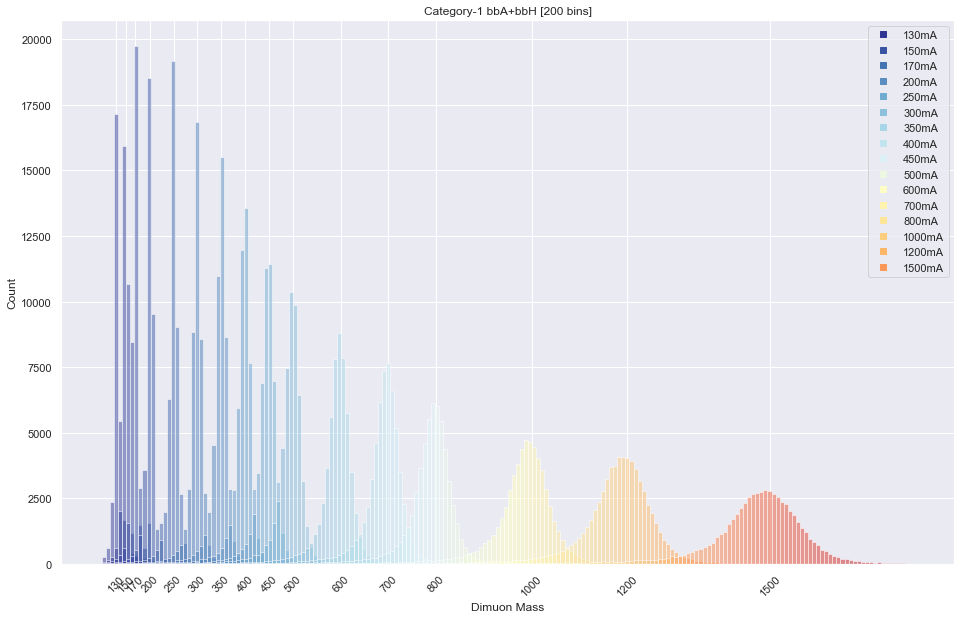

0

In [88]:
# https://stackoverflow.com/questions/23061657/plot-histogram-with-colors-taken-from-colormap

plt.figure(figsize=(16, 10))

cmap = plt.cm.get_cmap('RdYlBu_r')
colors = []

for m in mass:
    s = sig[sig['mA'] == m]
    n, bins, patches = plt.hist(s['dimuon_mass'], bins=200, label=f'{int(m)}mA', 
                                alpha=0.5, range=(100, 1800))
    
    # set cmap to each bin column
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for i, (c, p) in enumerate(zip(col, patches)):
        plt.setp(p, 'facecolor', cmap(c))
        
        if i == 100:
            colors.append(p)
    
plt.title('Category-1 bbA+bbH [200 bins]')
plt.xlabel('Dimuon Mass')
plt.ylabel('Count')

plt.xticks(mass, rotation=45)

import matplotlib.lines as mlines

handles = []
cmap = plt.cm.get_cmap('RdYlBu_r')

for i, m in enumerate(mass):
    handles.append(mlines.Line2D([], [], color=cmap(i * 11 + i + i // 2), marker='s', 
                                 ls='', label=f'{int(m)}mA'))

# etc etc
plt.legend(handles=handles, loc='best')

# plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# legend = plt.legend(loc='best')
# legend = plt.gca().get_legend()

# https://stackoverflow.com/questions/23698850/manually-set-color-of-points-in-legend
# for i, handle in enumerate(legend.legendHandles):
#     handle.set_color(colors[i].get_facecolor())
#     handle.set_facecolor(colors[i].get_facecolor())

plt.show()
free_mem()

Variables-related plots:

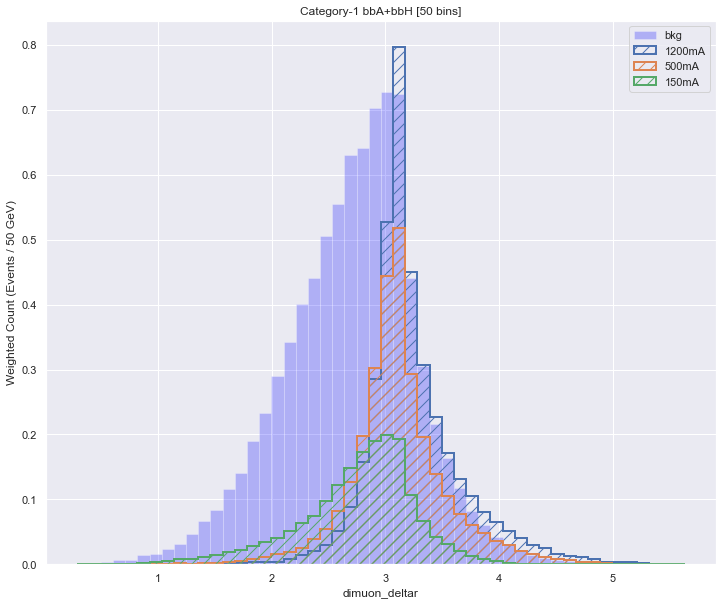

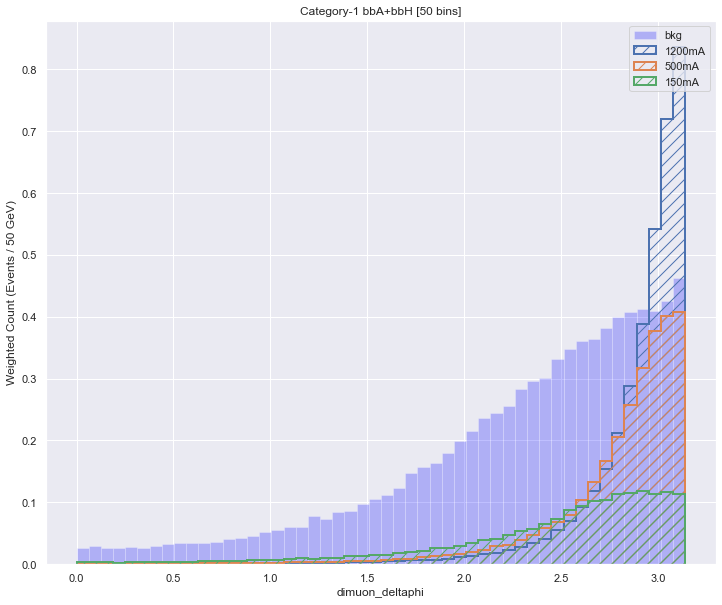

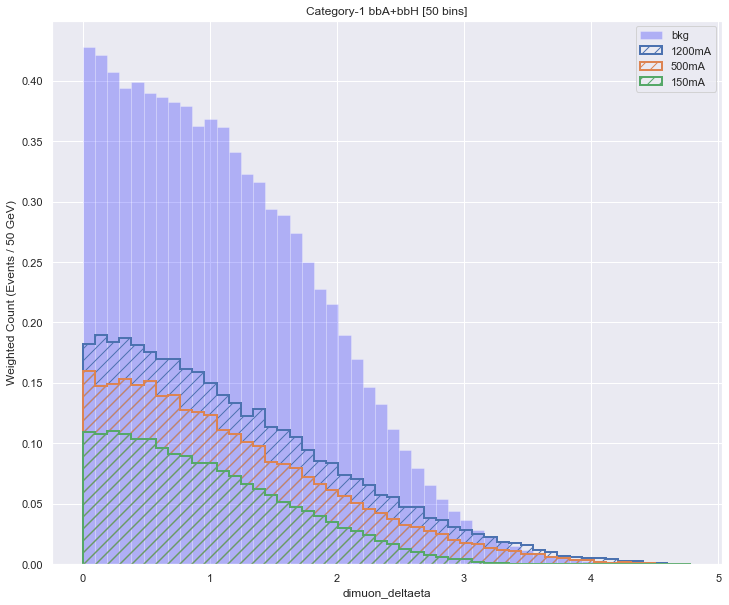

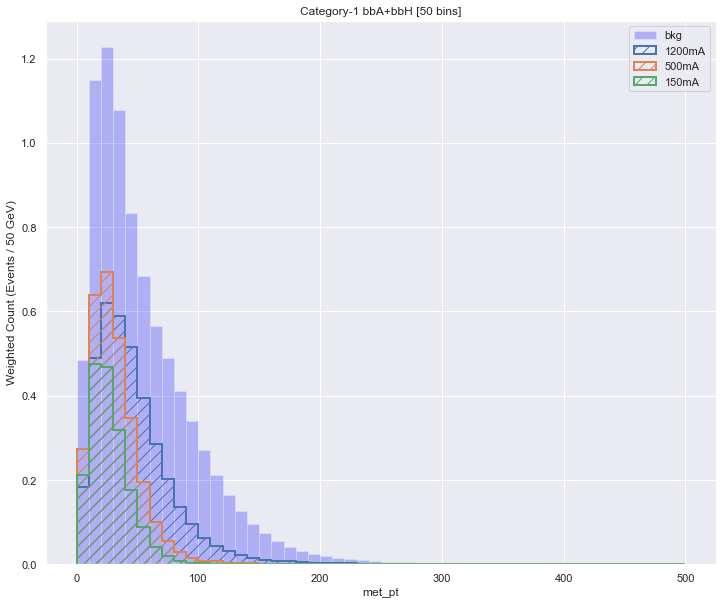

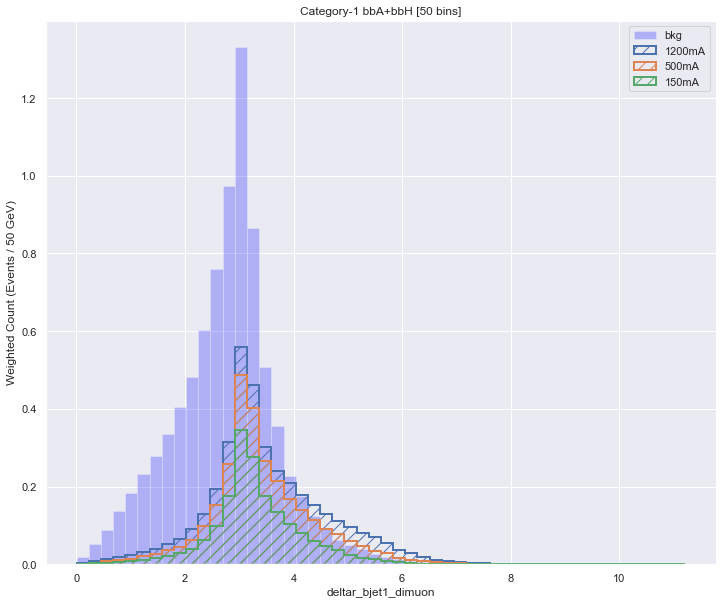

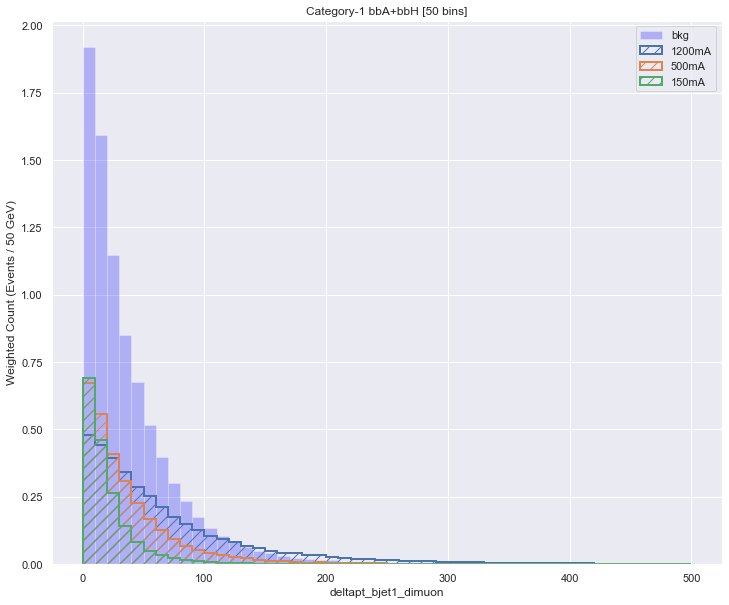

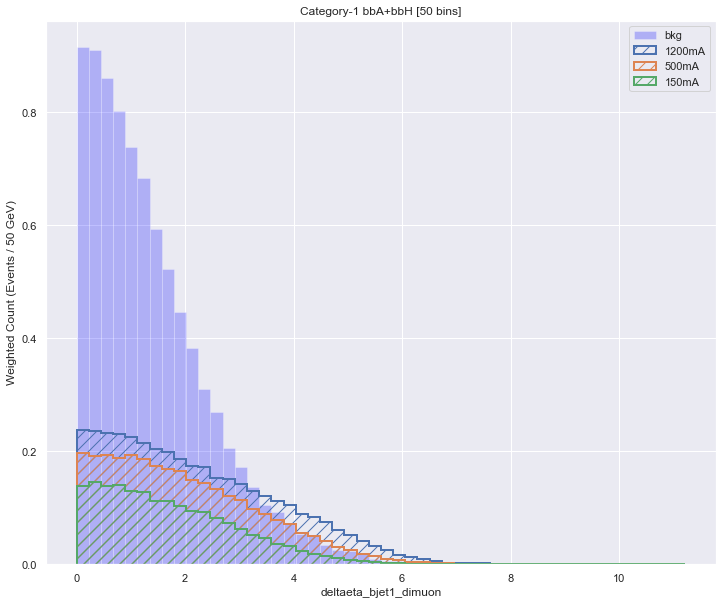

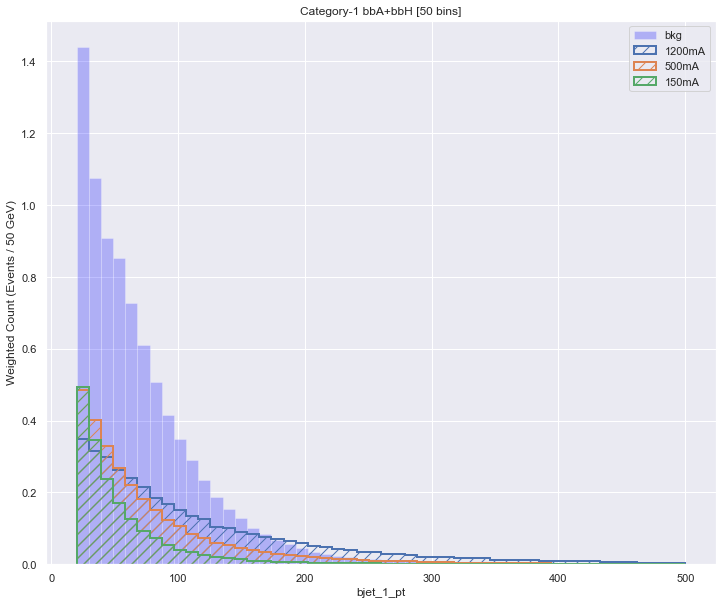

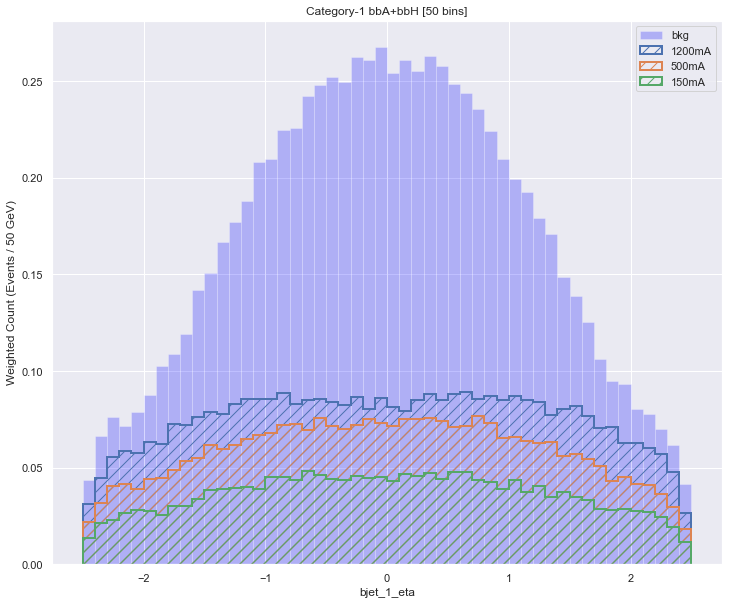

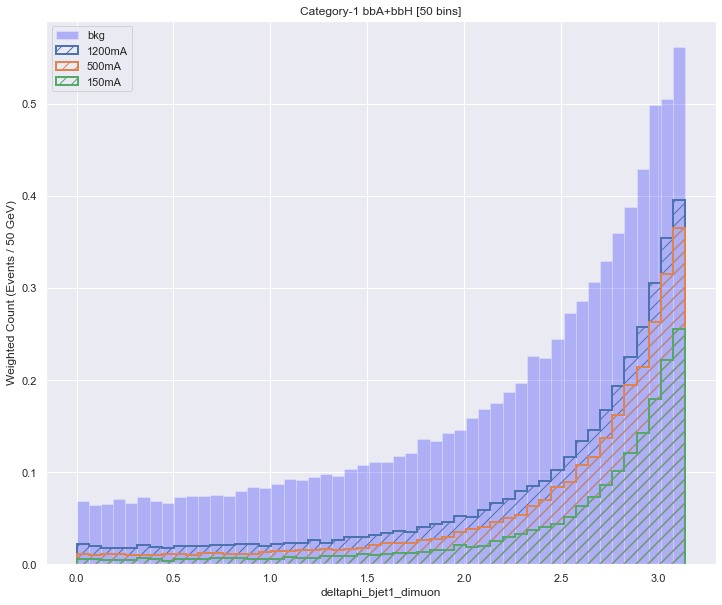

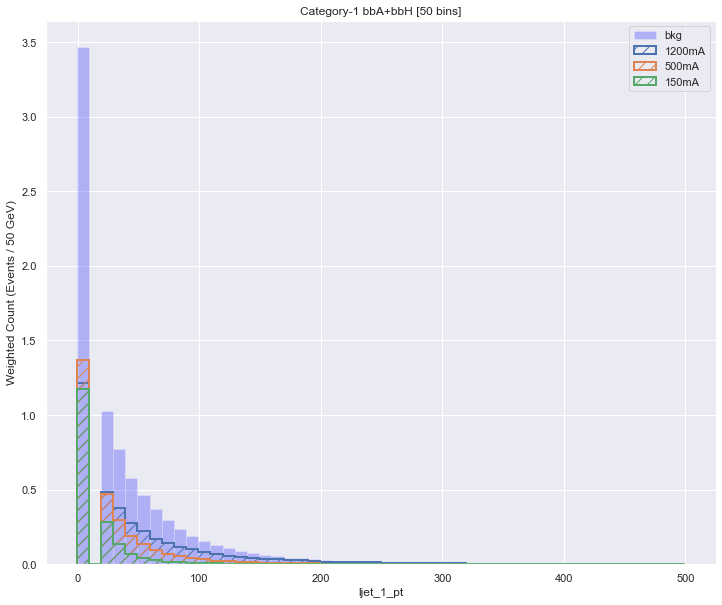

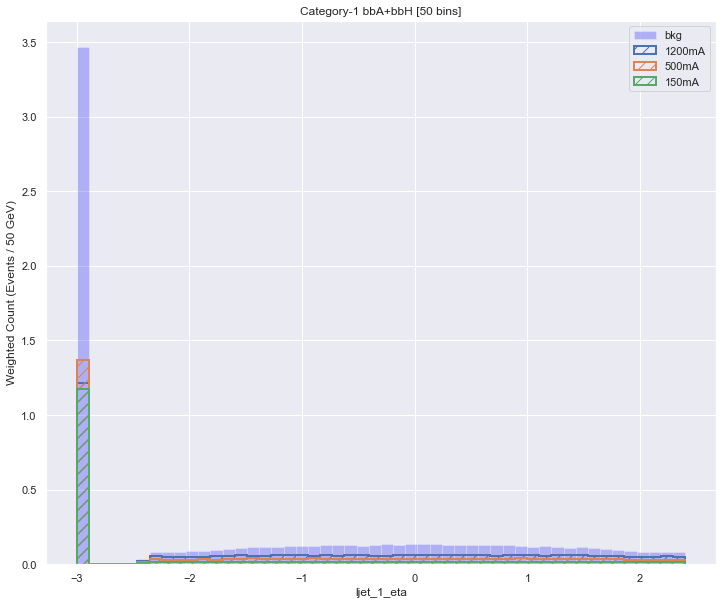

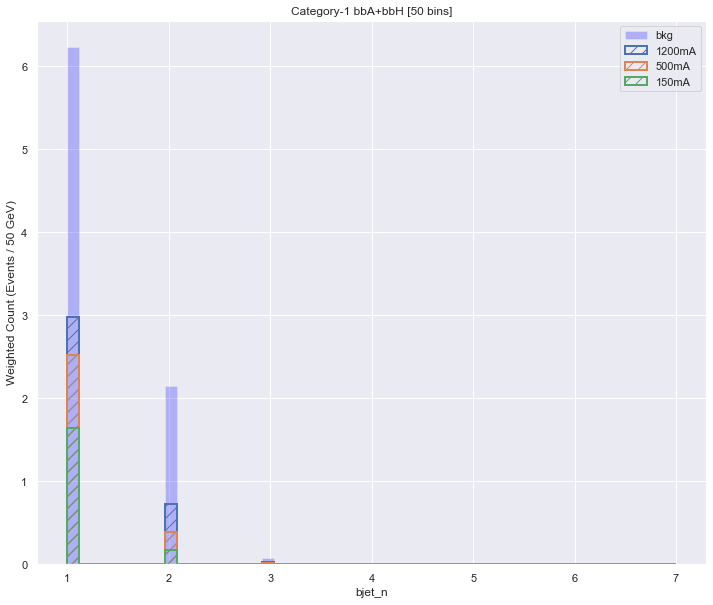

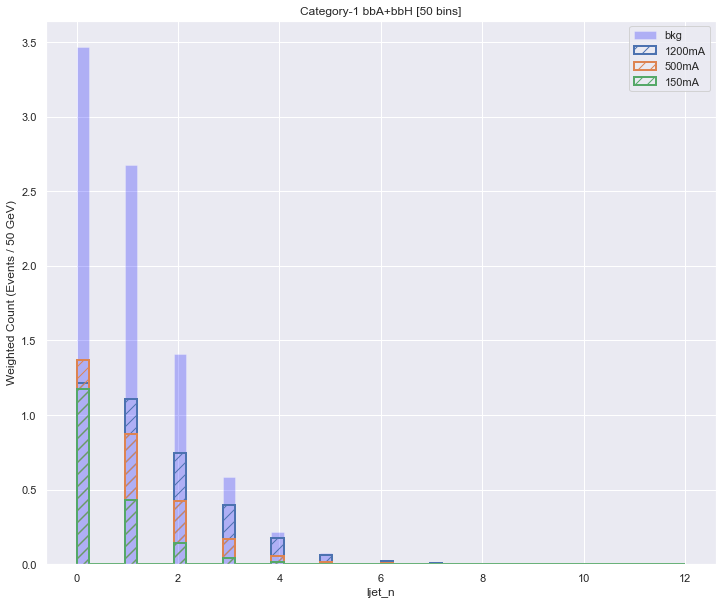

In [140]:
for var in VAR_CAT1:
    plot_var(data, variable=var, mass=[150, 500, 1200], limit=500.0, title='Category-1 bbA+bbH')

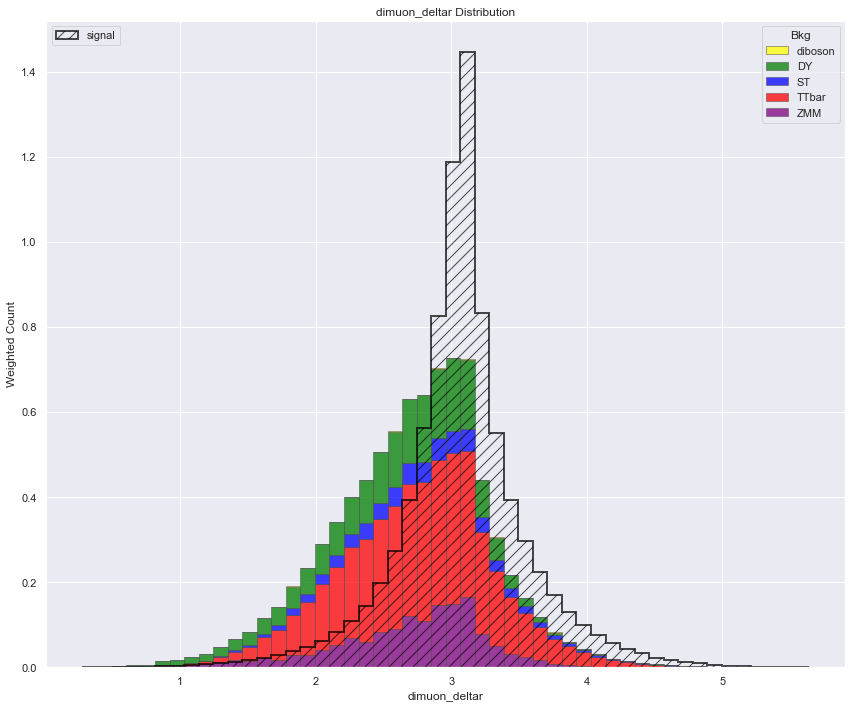

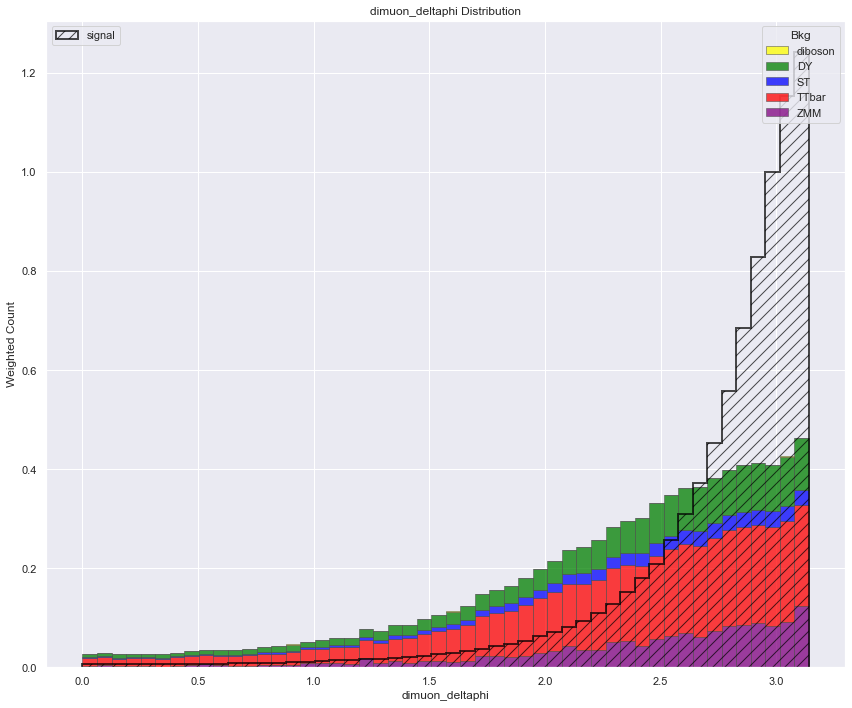

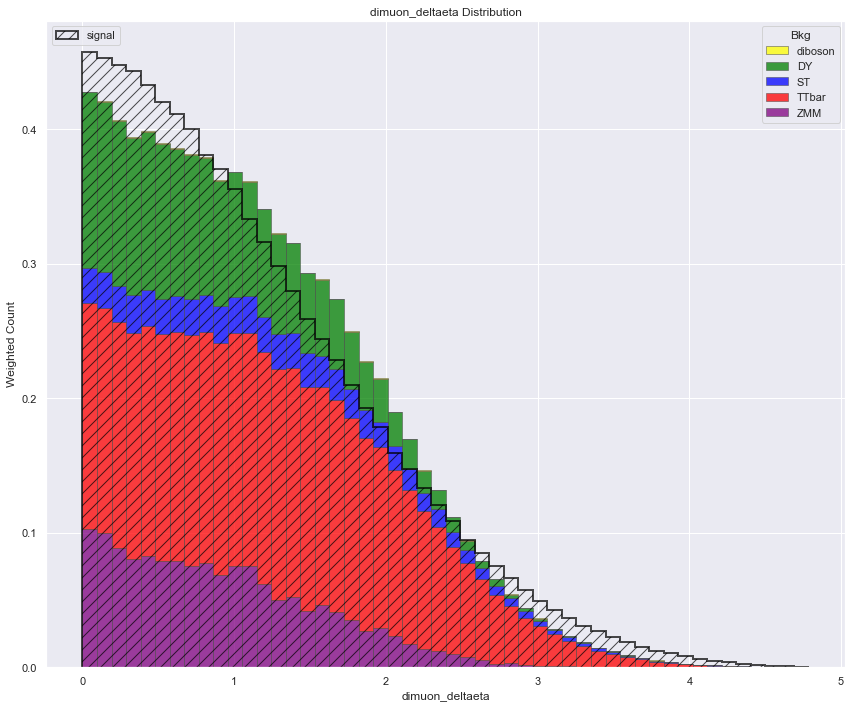

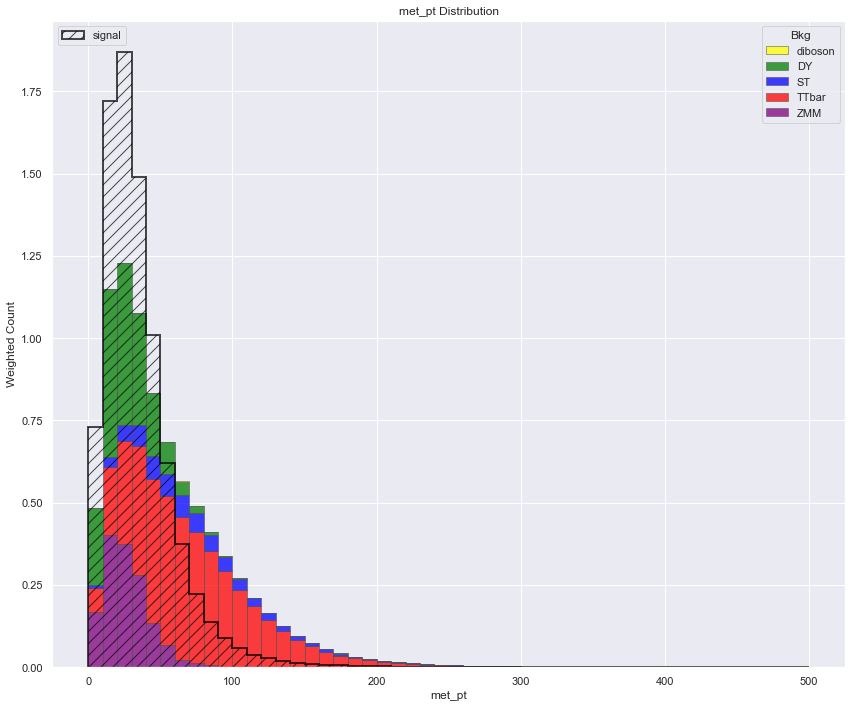

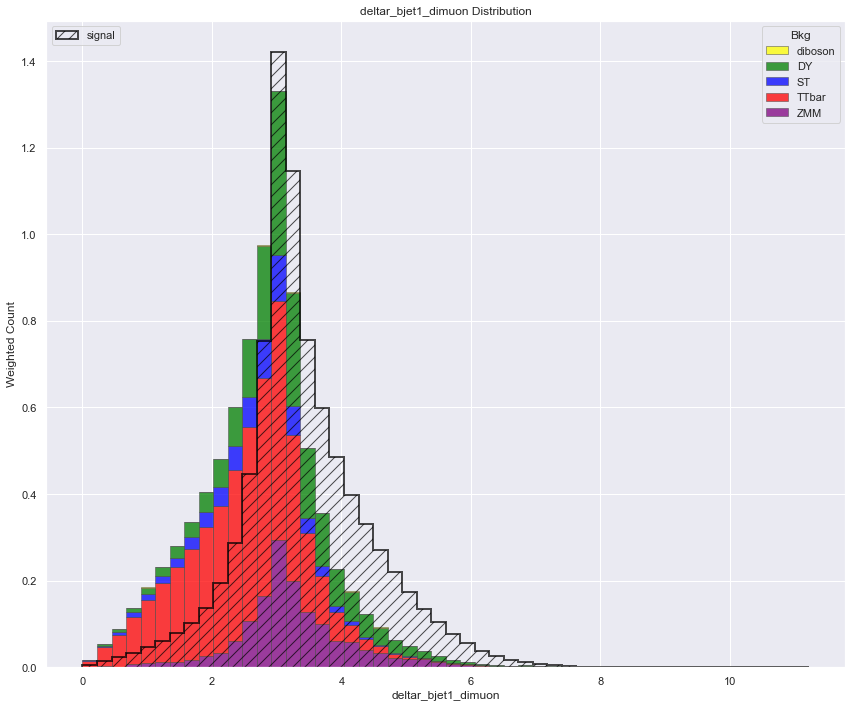

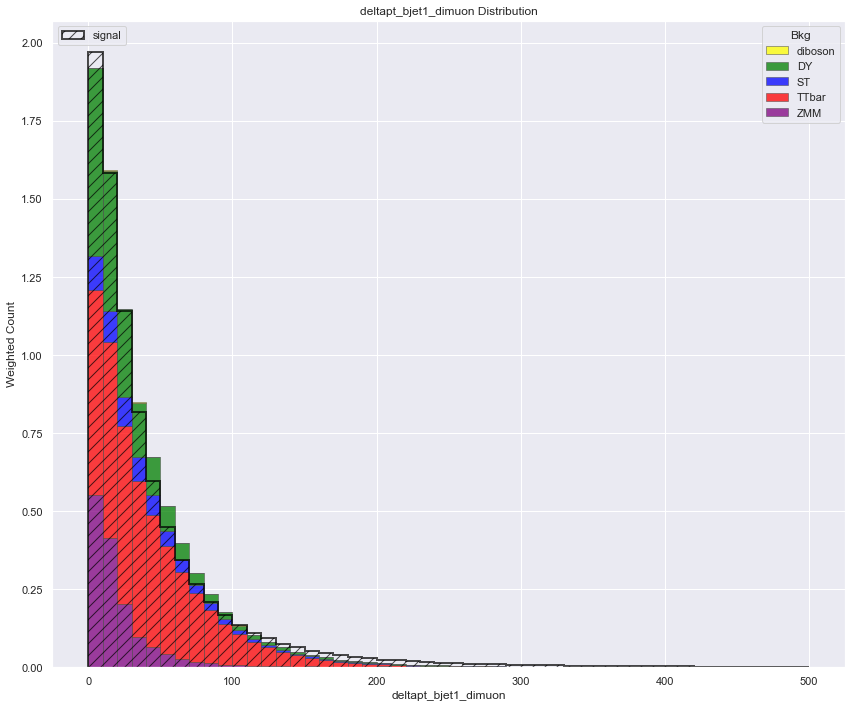

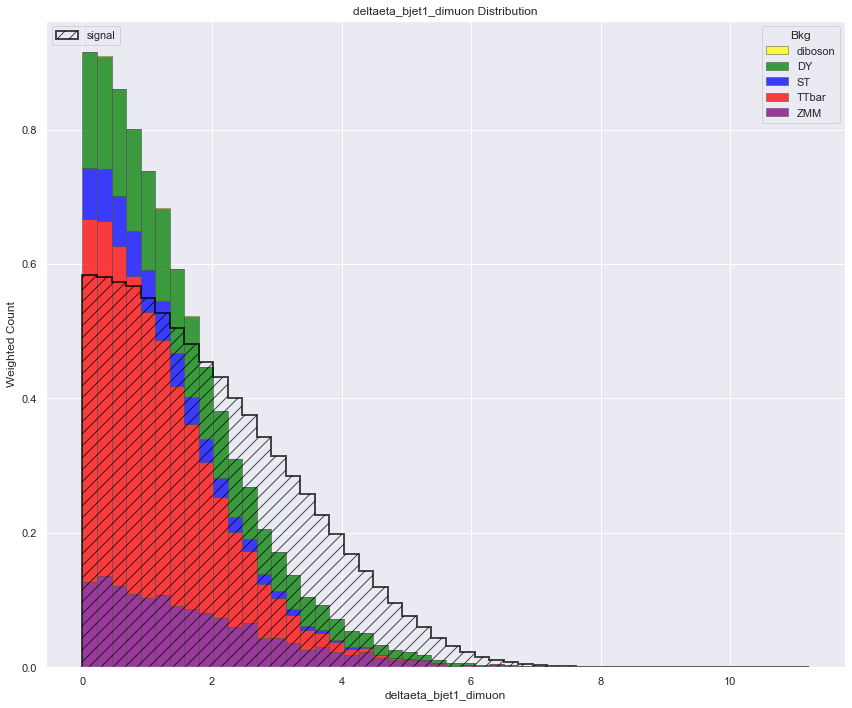

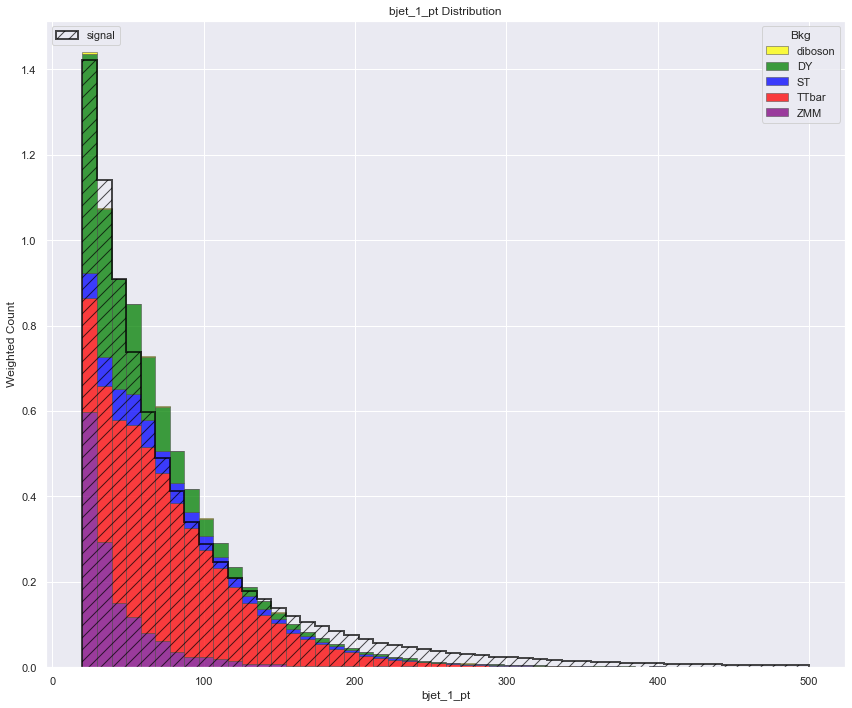

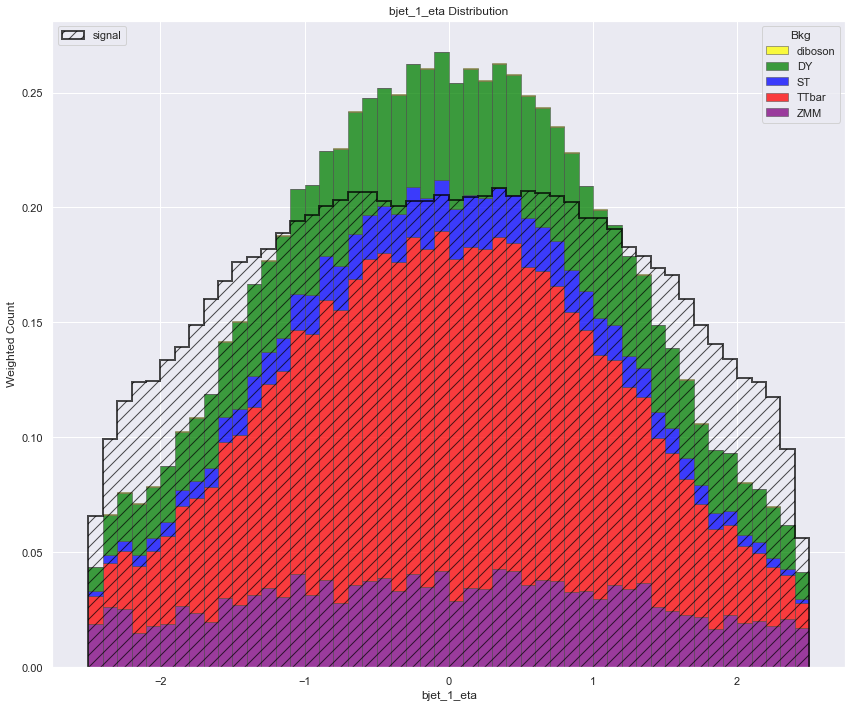

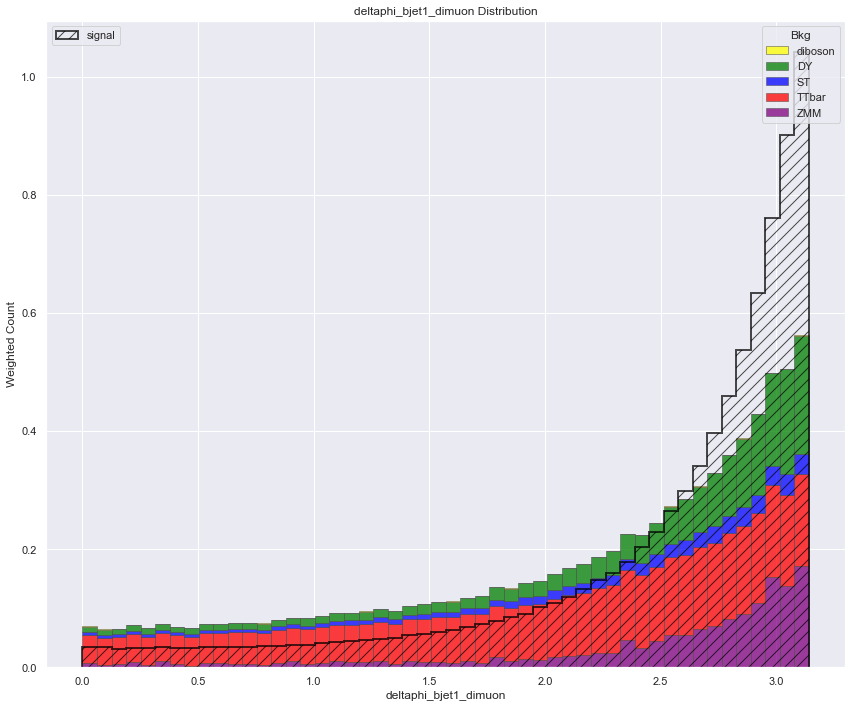

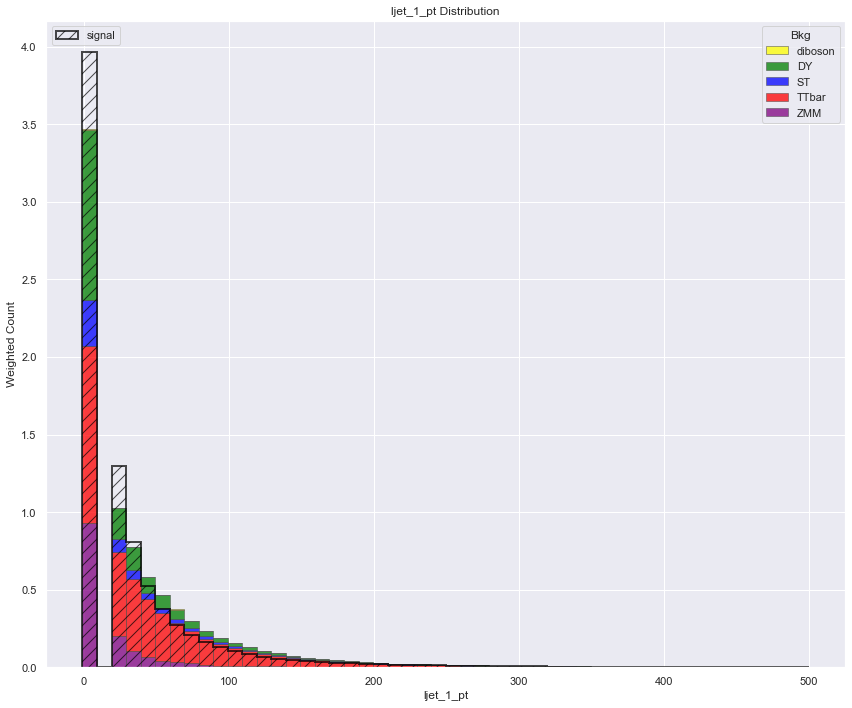

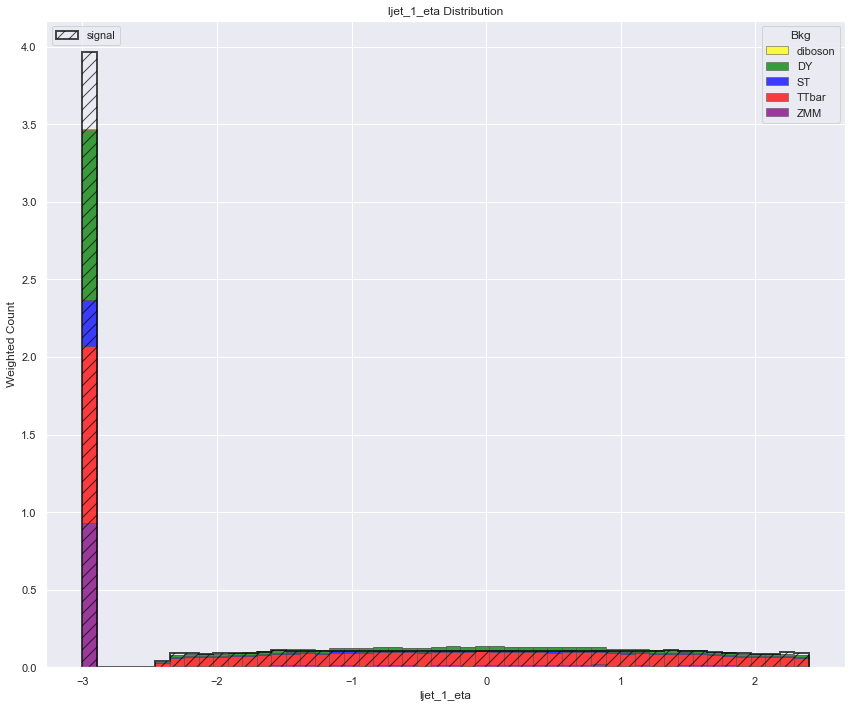

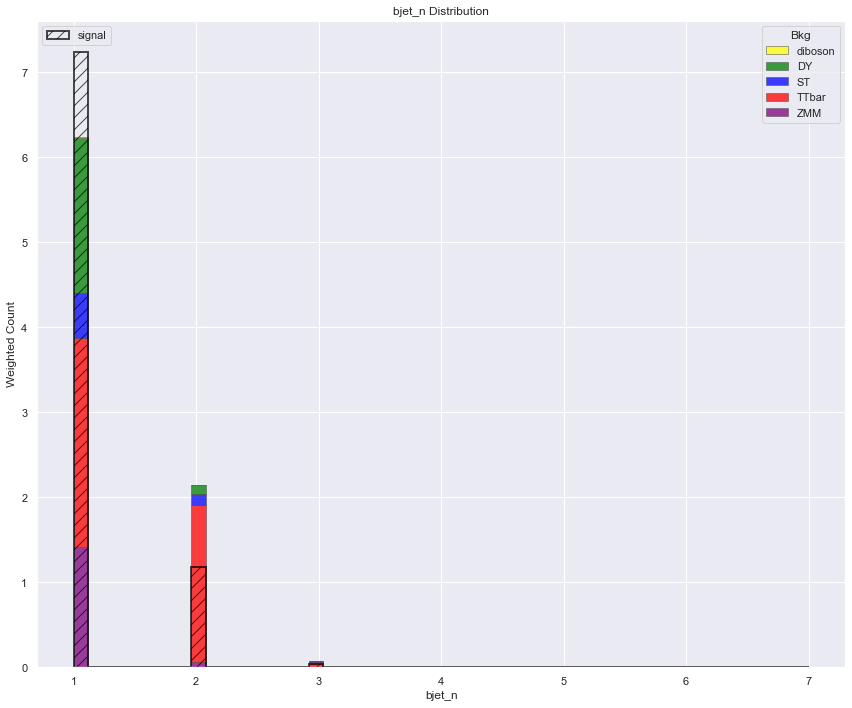

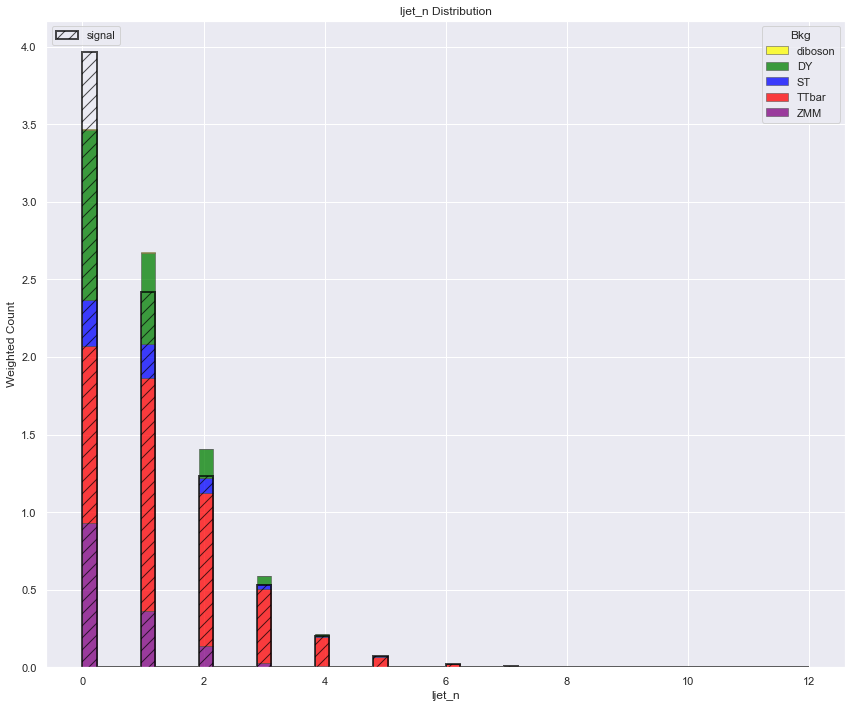

In [144]:
# variable plot on all data and mA
for var in VAR_CAT1:
    cms.plot.var(data, variable=var, bins=50, max_limit=500.0)

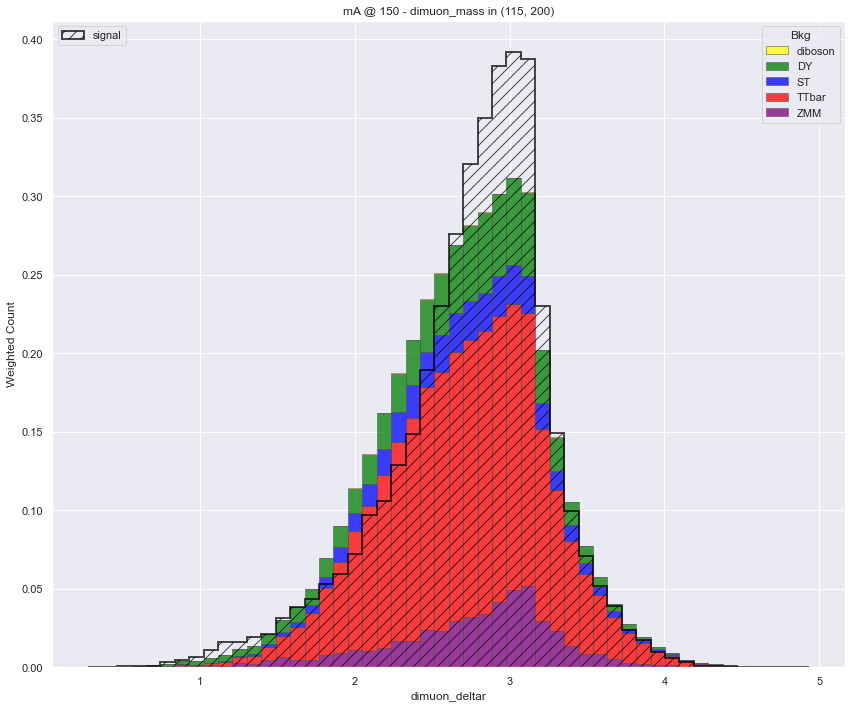

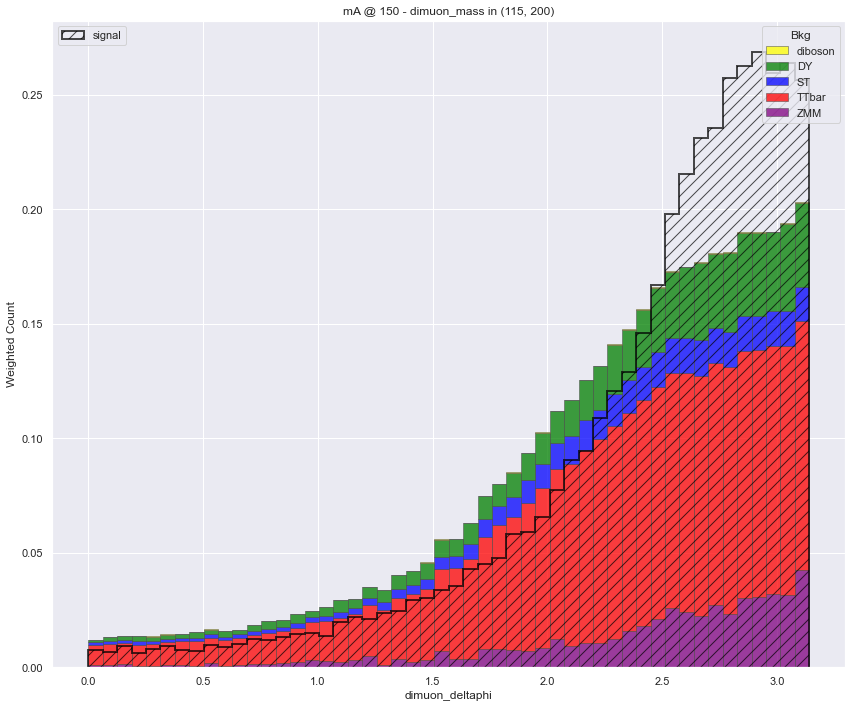

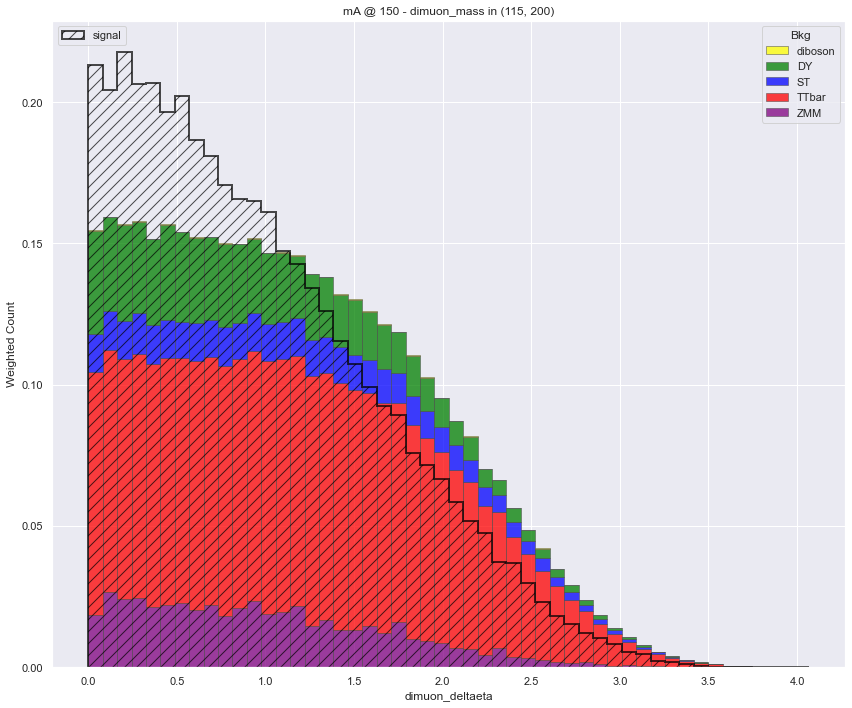

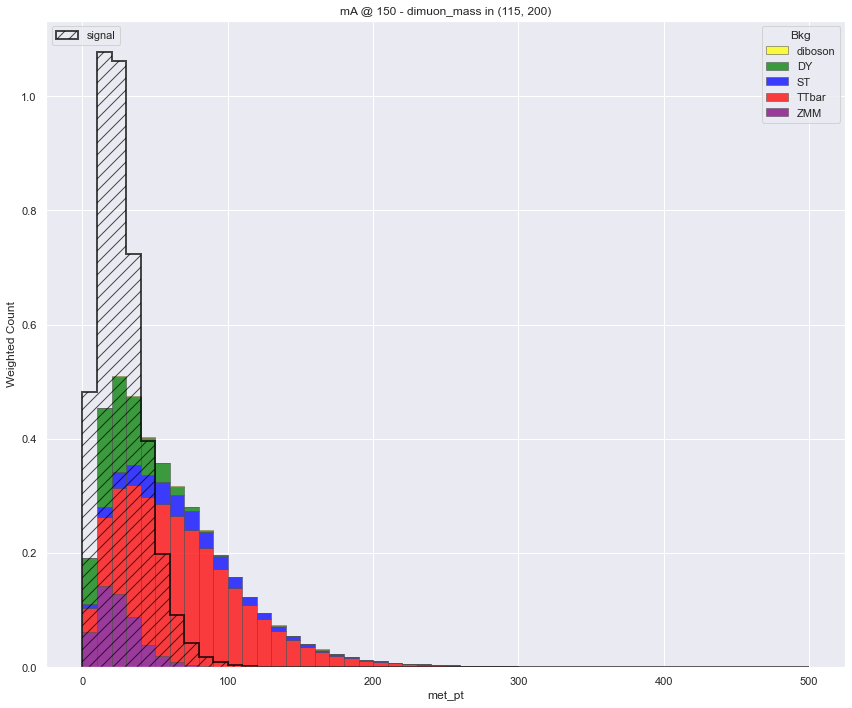

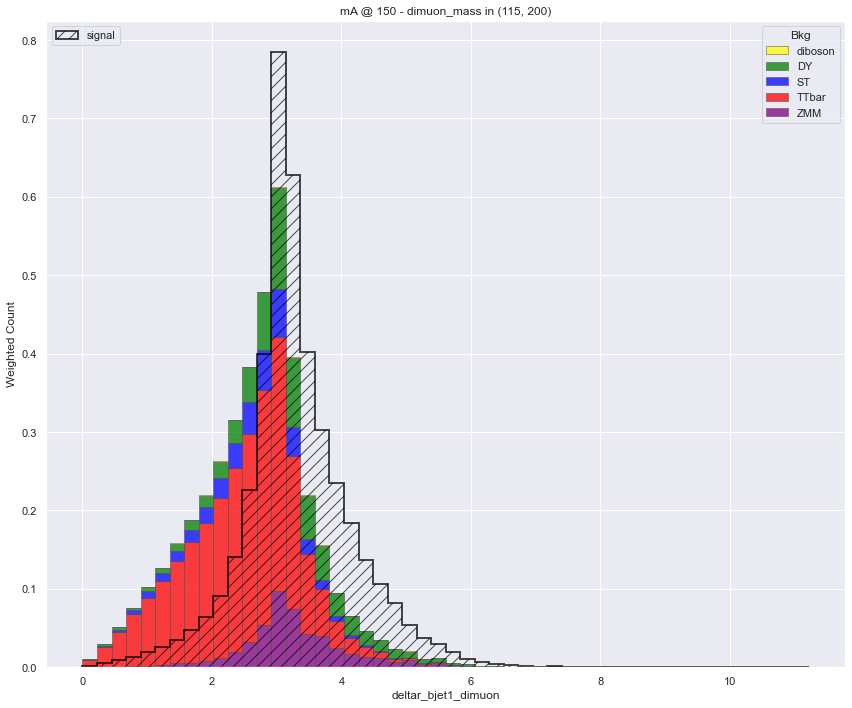

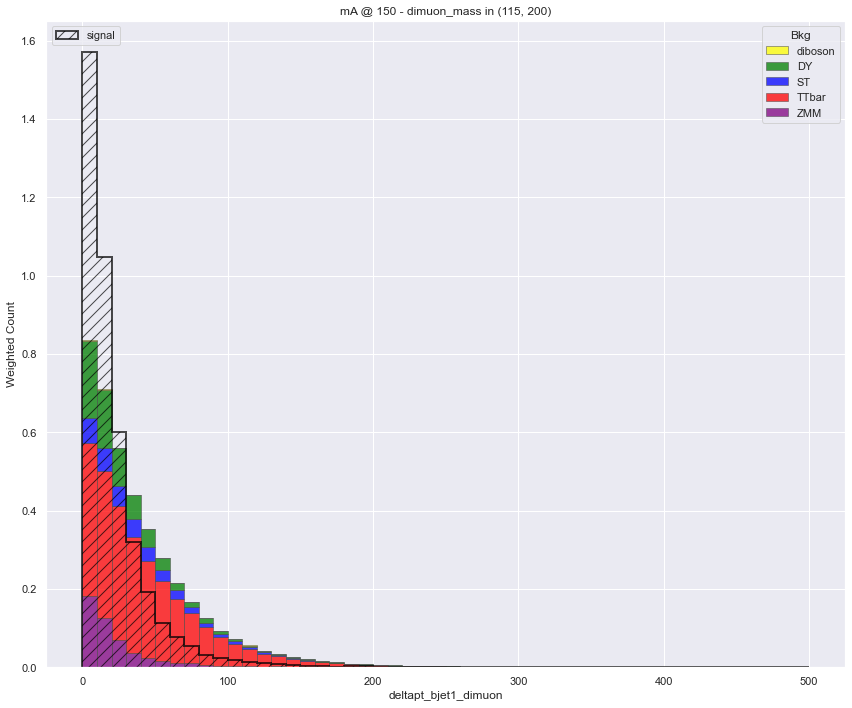

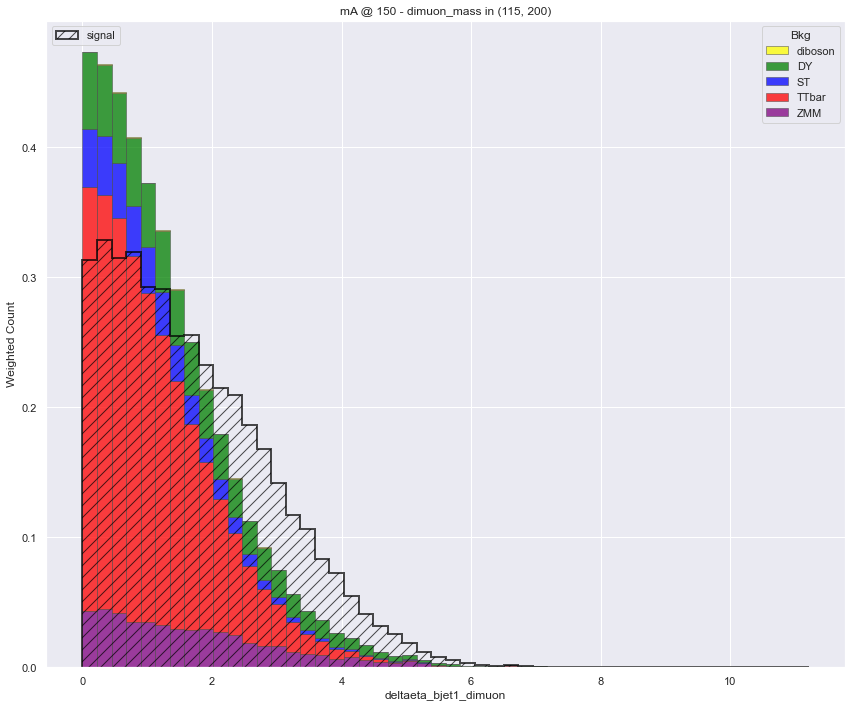

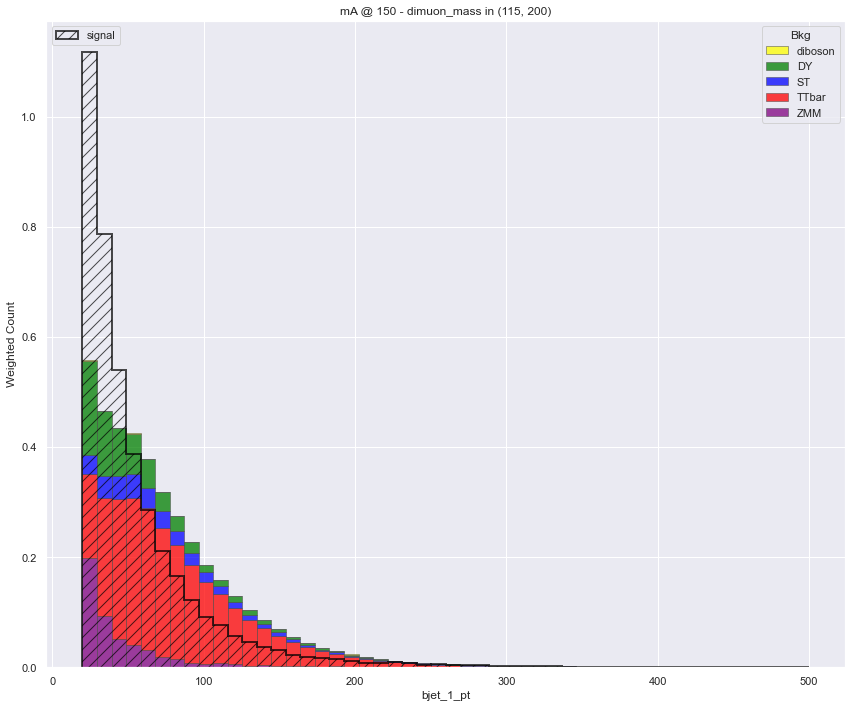

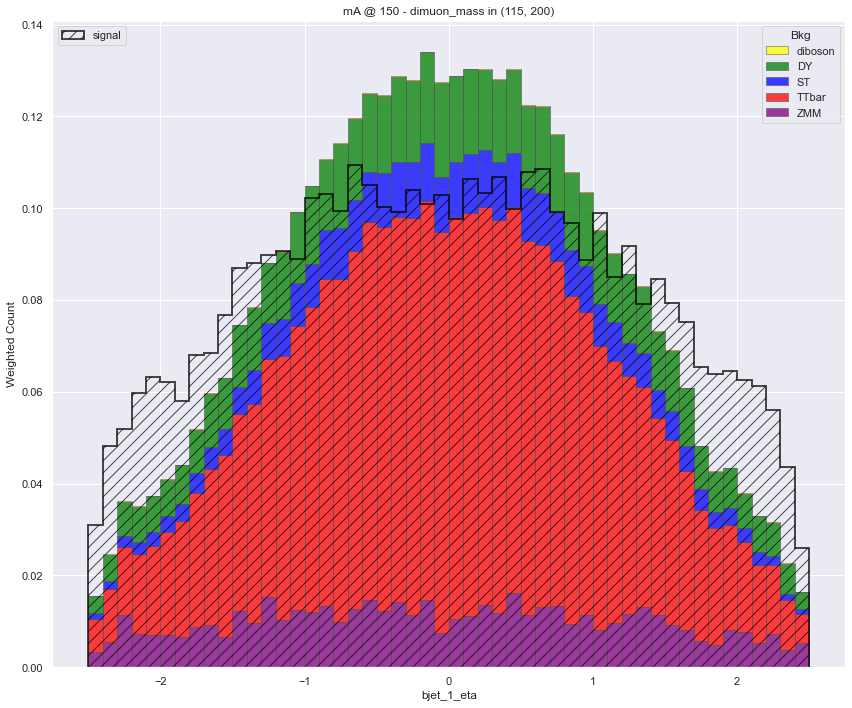

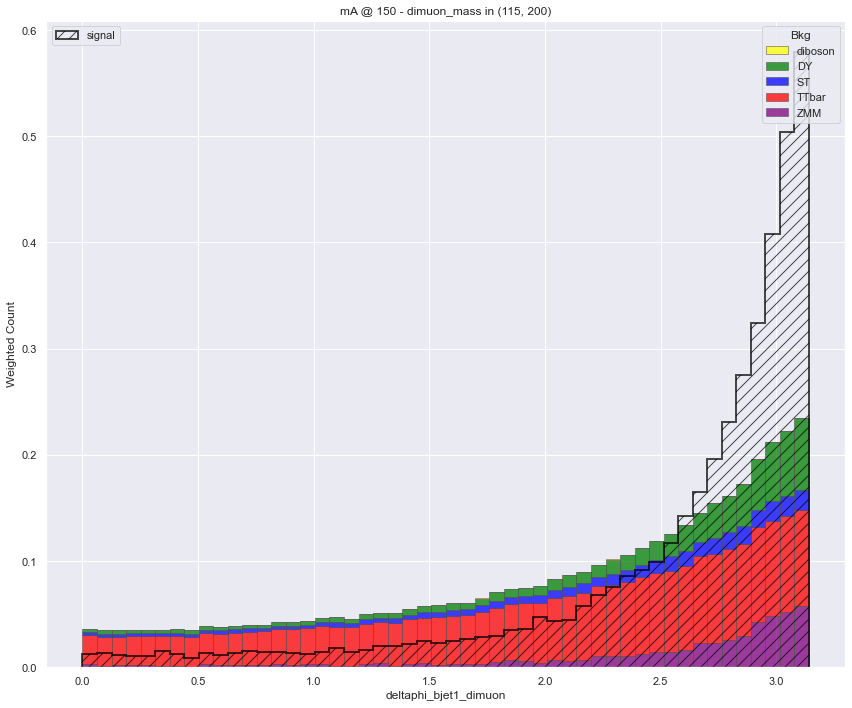

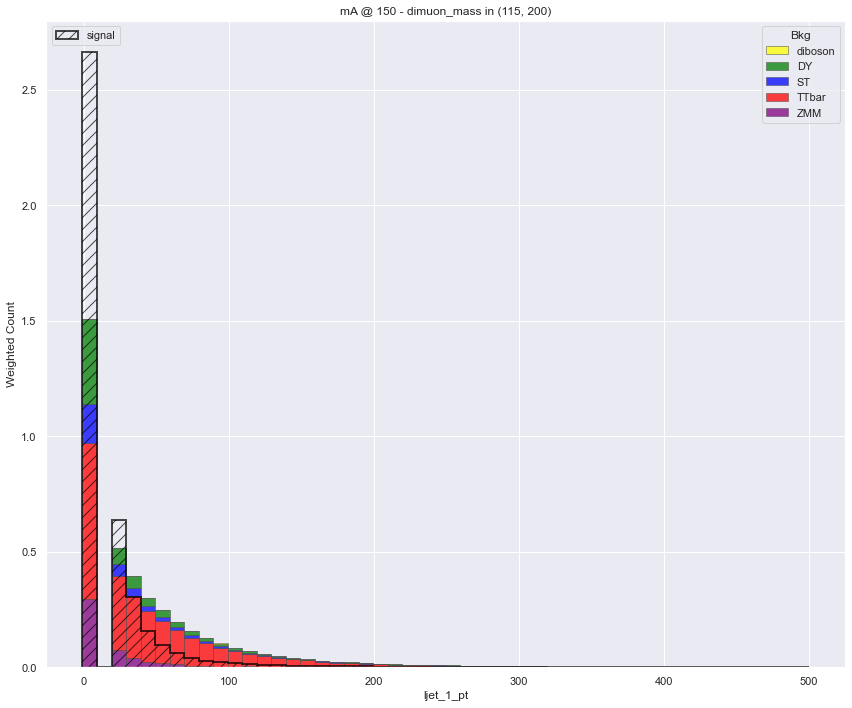

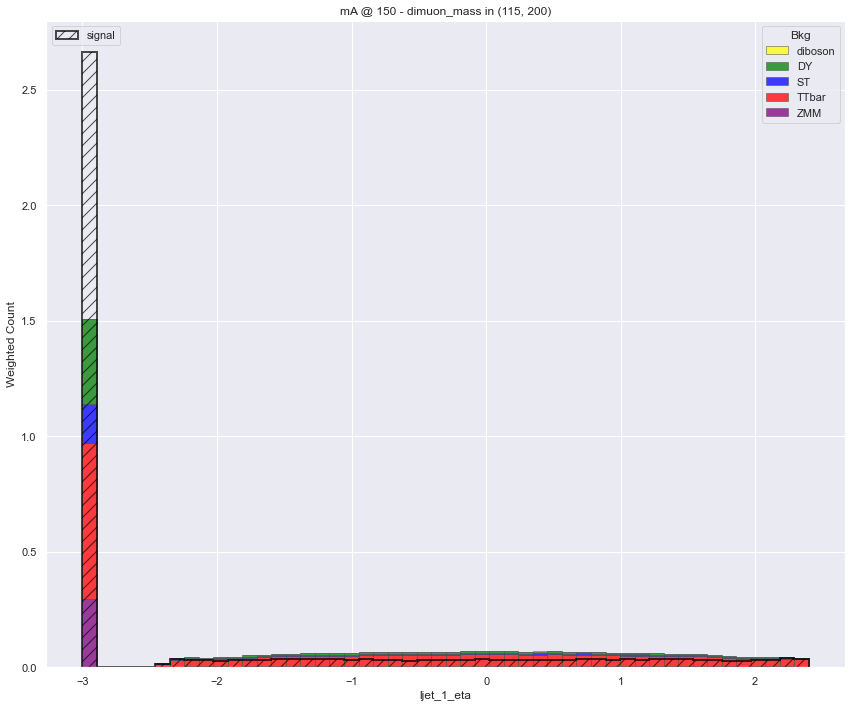

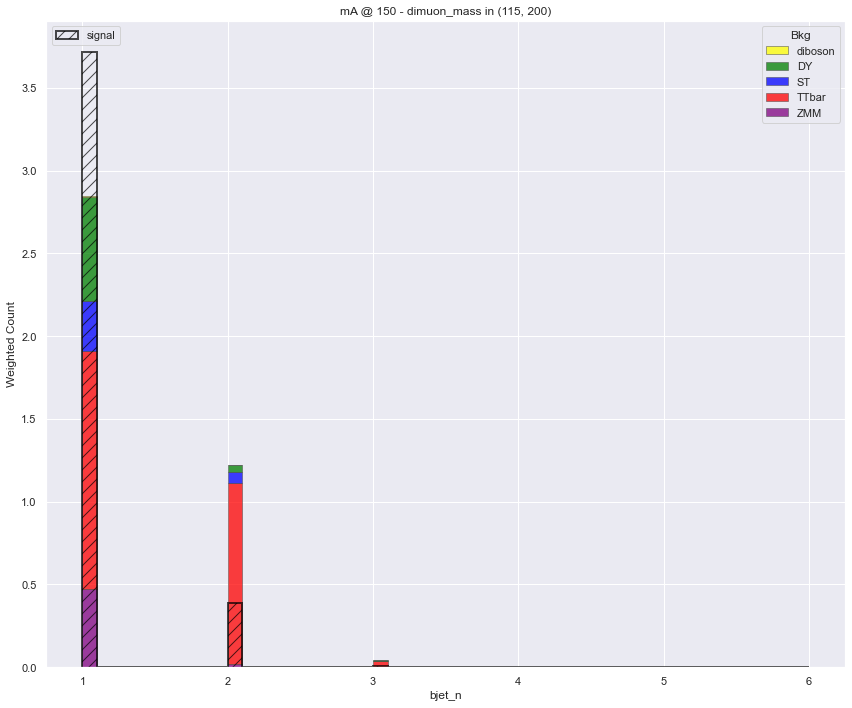

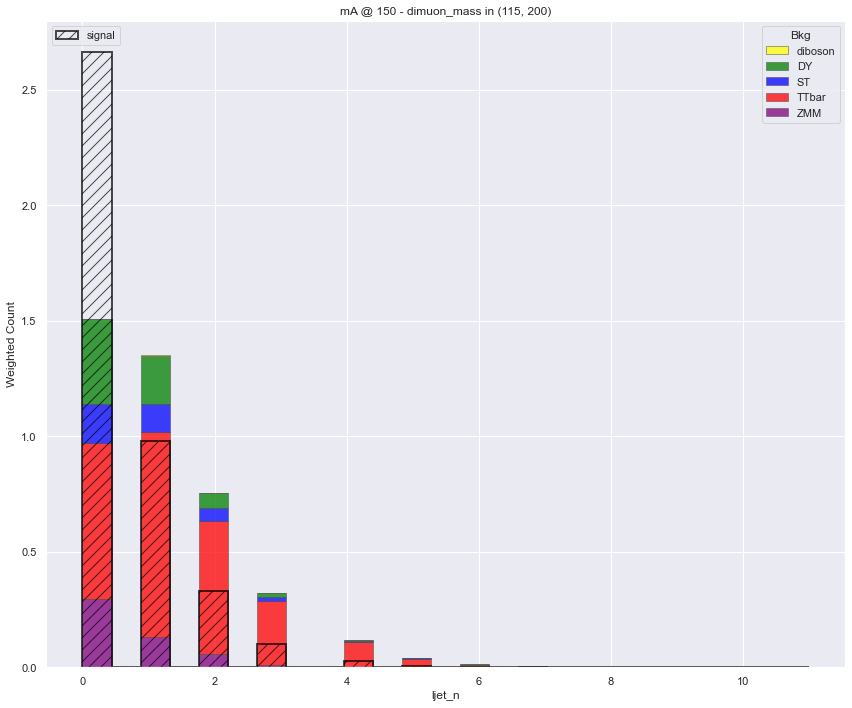

In [146]:
# input variables for a certain mA (and bkg in interval)
cms.plot.var_priori(data, variables=VAR_CAT1, mass=150, interval=INTERVALS[1], bins=50)

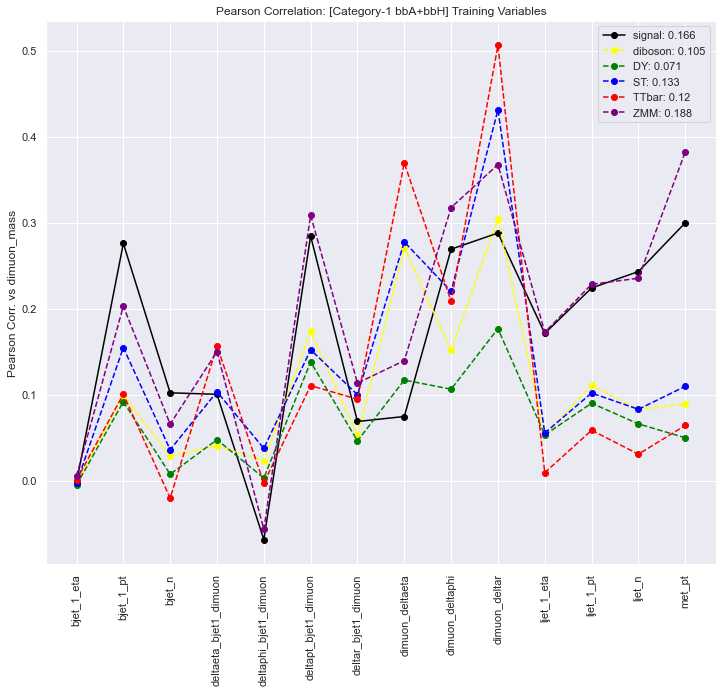

In [173]:
plot_corr(data, target='dimuon_mass', variables=VAR_CAT1, 
          title='[Category-1 bbA+bbH] Training Variables')

pNN-related plots:

In [147]:
mean = cms.retrieve_stat(cms.STATS_CAT1, which='mean', columns=VAR_CAT1)
std = cms.retrieve_stat(cms.STATS_CAT1, which='std', columns=VAR_CAT1)
clip = cms.retrieve_clip(cms.CLIP_CAT1, columns=VAR_CAT1)

preproc_layers = dict(x=[Clip(min_value=clip[:, 0], max_value=clip[:, 1]),
                         StandardScaler(mean=mean, std=std)],
                      m=[Divide(value=1000.0)])

In [148]:
model = utils.get_compiled_pnn(data, preprocess=preproc_layers, dropout=0.25)
utils.load_from_checkpoint(model, path='cat-1/pnn-preproc-drop-l2')

Loaded from "weights\cat-1/pnn-preproc-drop-l2\weights-33-0.930"


**bbA** (without `ZMM`):

In [155]:
bbA = cms.get_test_from_dataset(data, process='bbA')
bbA.mass_intervals = INTERVALS

[signal] loading...
[background] loading...
[Dataset] loaded.


In [149]:
CUT_CAT1_BBA_W = [0.42424242, 0.43434343, 0.46464646, 0.45454545, 0.43434343,
                  0.45454545, 0.46464646, 0.42424242, 0.43434343, 0.48484848,
                  0.46464646, 0.54545455, 0.52525253, 0.52525253, 0.51515152,
                  0.56565657]

Text(0.5, 1.0, '[ROC] Category-1 bbA')

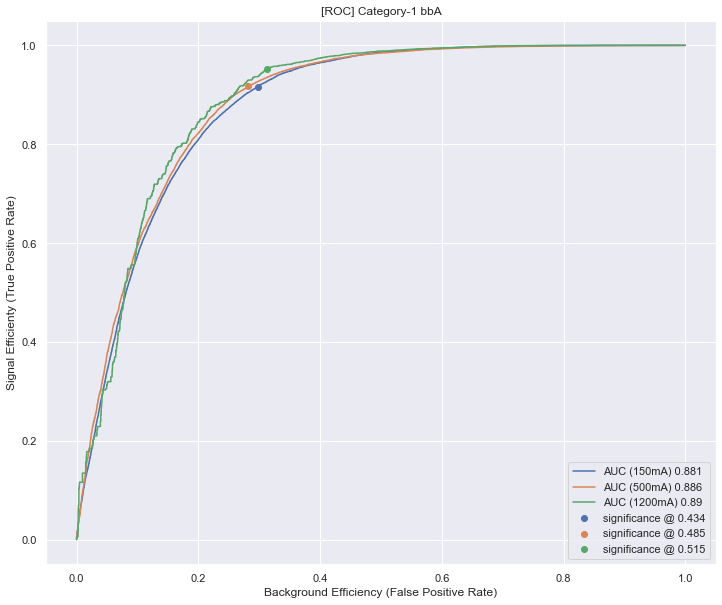

In [164]:
# ROC
fig = plt.figure(figsize=(12, 10))
ax = fig.gca()

cms.plot.compare_roc(bbA, models_and_cuts={'150mA': (model, CUT_CAT1_BBA_W[1])}, mass=150,
                     interval=INTERVALS[1], ax=ax, bins=100)

cms.plot.compare_roc(bbA, models_and_cuts={'500mA': (model, CUT_CAT1_BBA_W[9])}, mass=500,
                     interval=INTERVALS[9], ax=ax, bins=100)

cms.plot.compare_roc(bbA, models_and_cuts={'1200mA': (model, CUT_CAT1_BBA_W[-2])}, mass=1200,
                     interval=INTERVALS[-2], ax=ax, bins=100)

_ = ax.set_title('[ROC] Category-1 bbA')

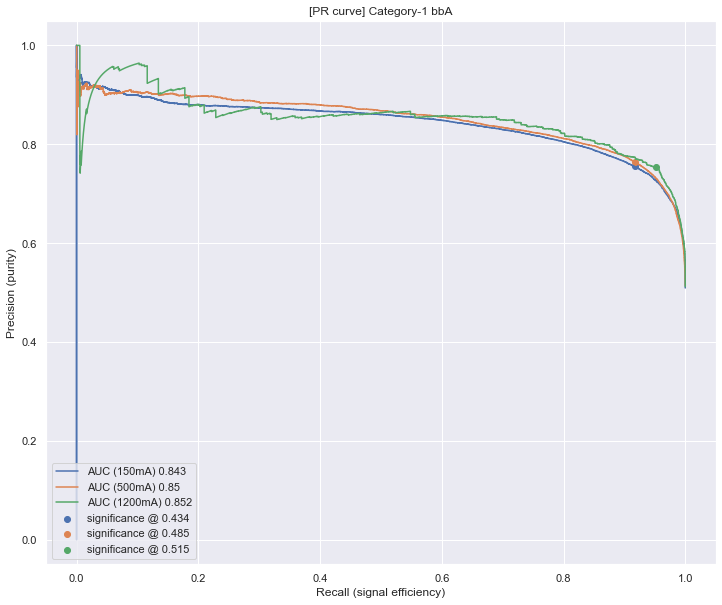

In [165]:
# PR
fig = plt.figure(figsize=(12, 10))
ax = fig.gca()

cms.plot.compare_pr(bbA, models_and_cuts={'150mA': (model, CUT_CAT1_BBA_W[1])}, mass=150,
                    interval=INTERVALS[1], ax=ax, bins=100)

cms.plot.compare_pr(bbA, models_and_cuts={'500mA': (model, CUT_CAT1_BBA_W[9])}, mass=500,
                    interval=INTERVALS[9], ax=ax, bins=100)

cms.plot.compare_pr(bbA, models_and_cuts={'1200mA': (model, CUT_CAT1_BBA_W[-2])}, mass=1200,
                    interval=INTERVALS[-2], ax=ax, bins=100)

_ = ax.set_title('[PR curve] Category-1 bbA')

**bbH** (without `ZMM`):

In [166]:
bbH = cms.get_test_from_dataset(data, process='bbH')
bbH.mass_intervals = INTERVALS

[signal] loading...
[background] loading...
[Dataset] loaded.


In [167]:
CUT_CAT1_BBH_W = [0.46464646, 0.49494949, 0.45454545, 0.47474747, 0.41414141,
                  0.45454545, 0.46464646, 0.41414141, 0.49494949, 0.42424242,
                  0.47474747, 0.50505051, 0.52525253, 0.52525253, 0.51515152,
                  0.56565657]

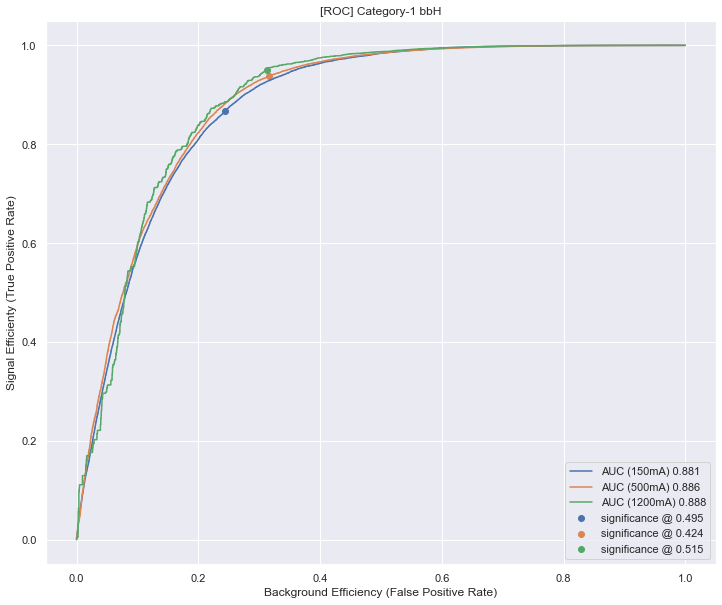

In [168]:
# ROC
fig = plt.figure(figsize=(12, 10))
ax = fig.gca()

cms.plot.compare_roc(bbH, models_and_cuts={'150mA': (model, CUT_CAT1_BBH_W[1])}, mass=150,
                     interval=INTERVALS[1], ax=ax, bins=100)

cms.plot.compare_roc(bbH, models_and_cuts={'500mA': (model, CUT_CAT1_BBH_W[9])}, mass=500,
                     interval=INTERVALS[9], ax=ax, bins=100)

cms.plot.compare_roc(bbH, models_and_cuts={'1200mA': (model, CUT_CAT1_BBH_W[-2])}, mass=1200,
                     interval=INTERVALS[-2], ax=ax, bins=100)

_ = ax.set_title('[ROC] Category-1 bbH')

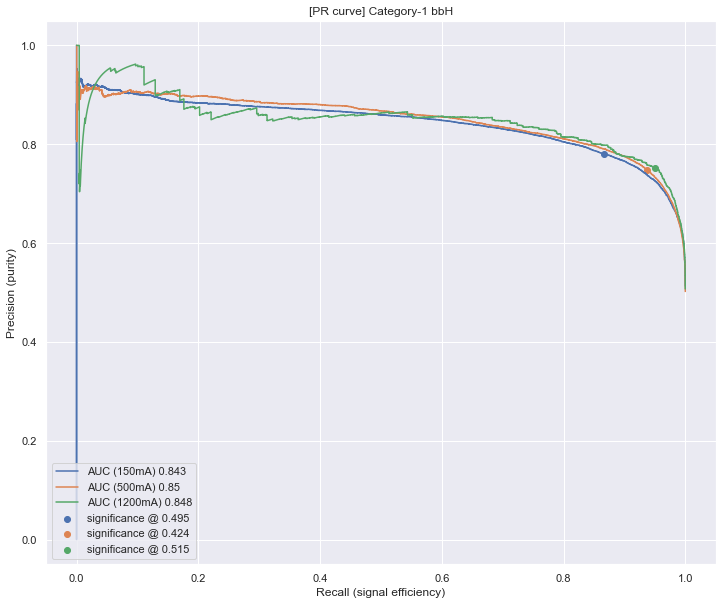

In [169]:
# PR
fig = plt.figure(figsize=(12, 10))
ax = fig.gca()

cms.plot.compare_pr(bbH, models_and_cuts={'150mA': (model, CUT_CAT1_BBH_W[1])}, mass=150,
                    interval=INTERVALS[1], ax=ax, bins=100)

cms.plot.compare_pr(bbH, models_and_cuts={'500mA': (model, CUT_CAT1_BBH_W[9])}, mass=500,
                    interval=INTERVALS[9], ax=ax, bins=100)

cms.plot.compare_pr(bbH, models_and_cuts={'1200mA': (model, CUT_CAT1_BBH_W[-2])}, mass=1200,
                    interval=INTERVALS[-2], ax=ax, bins=100)

_ = ax.set_title('[PR curve] Category-1 bbH')

## Category-2

In [8]:
VAR_CAT2 = ["dimuon_deltar", "dimuon_deltaphi", "dimuon_deltaeta", "met_pt",
            "ljet_1_pt", "ljet_1_eta", "ljet_n"]

In [9]:
# load *all* data
data = Dataset()
data.load(signal='data/new2/signal_bassociated_cat2.csv', 
          bkg='data/new2/background_cat2.csv', feature_columns=VAR_CAT2)

for df in [data.signal, data.background, data.ds]:
    df.loc[df['ljet_1_eta'] <= -10, 'ljet_1_eta'] = -3.0

data.mass_intervals = INTERVALS

[signal] loading...
[background] loading...
[Dataset] loaded.


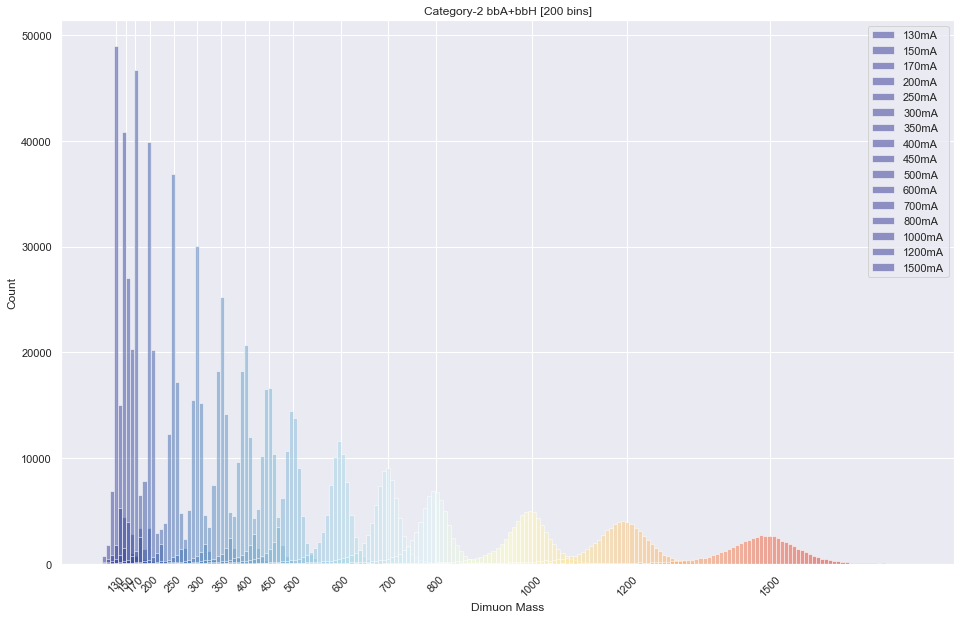

0

In [12]:
plt.figure(figsize=(16, 10))

cmap = plt.cm.get_cmap('RdYlBu_r')
colors = []

for m in data.unique_signal_mass:
    s = data.signal[data.signal['mA'] == m]
    n, bins, patches = plt.hist(s['dimuon_mass'], bins=200, label=f'{int(m)}mA', 
                                alpha=0.5, range=(100, 1800))
    
    # set cmap to each bin column
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for i, (c, p) in enumerate(zip(col, patches)):
        plt.setp(p, 'facecolor', cmap(c))
        
        if i == 100:
            colors.append(p)
    
plt.title('Category-2 bbA+bbH [200 bins]')
plt.xlabel('Dimuon Mass')
plt.ylabel('Count')

plt.xticks(data.unique_signal_mass, rotation=45)
plt.legend(loc='best')

plt.show()
free_mem()

Variables-related plots:

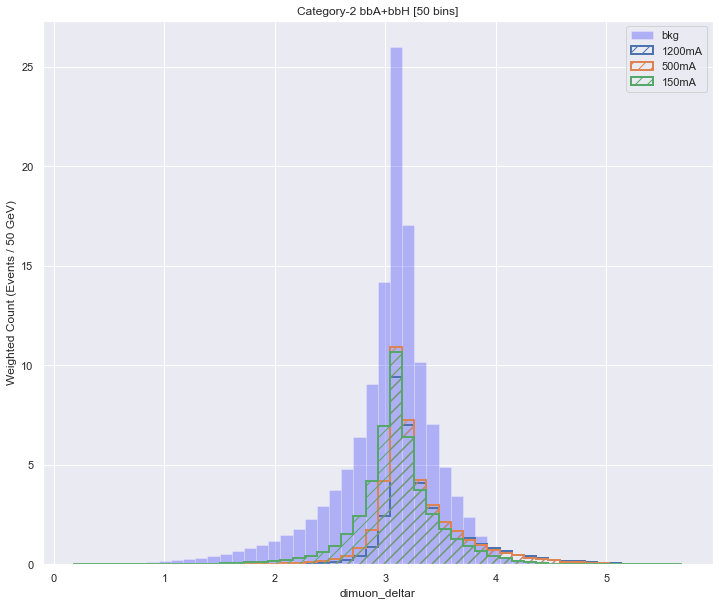

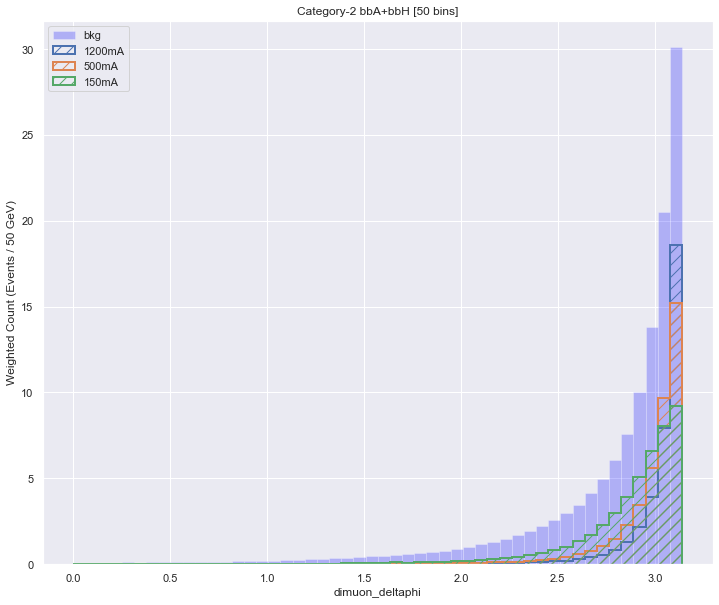

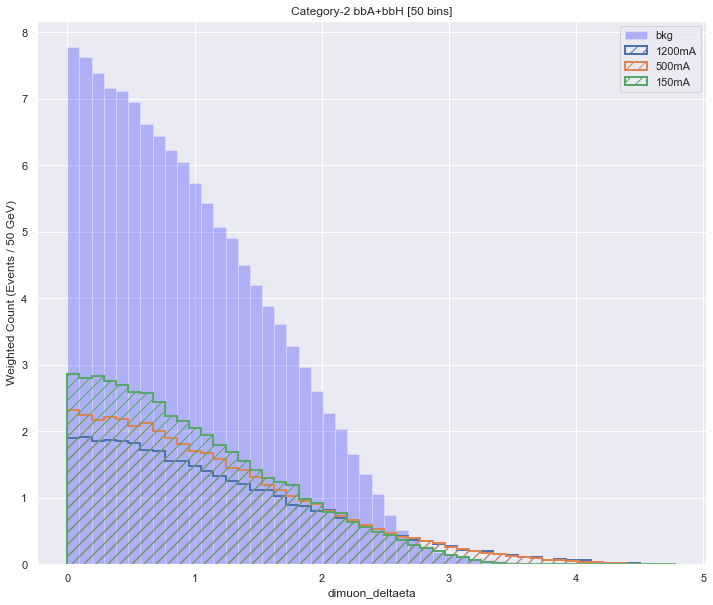

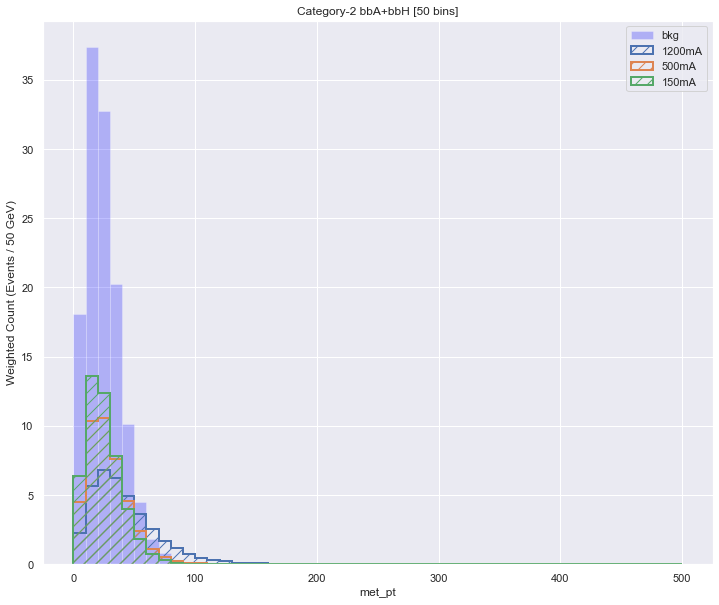

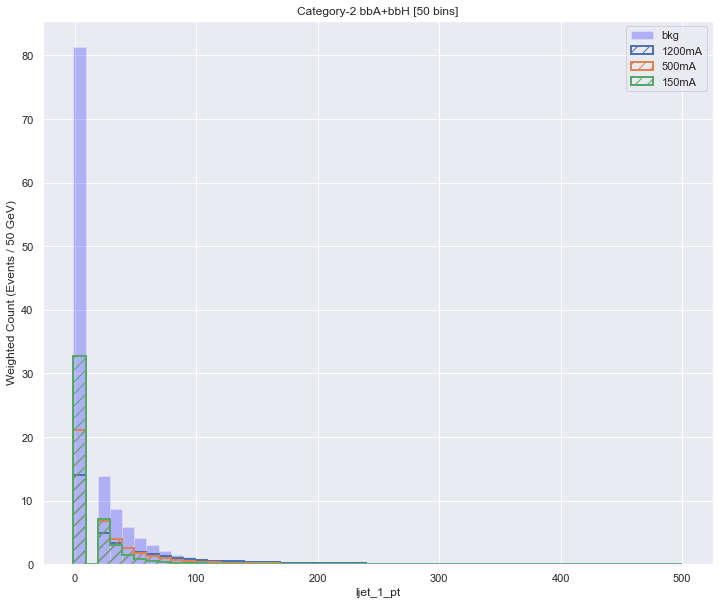

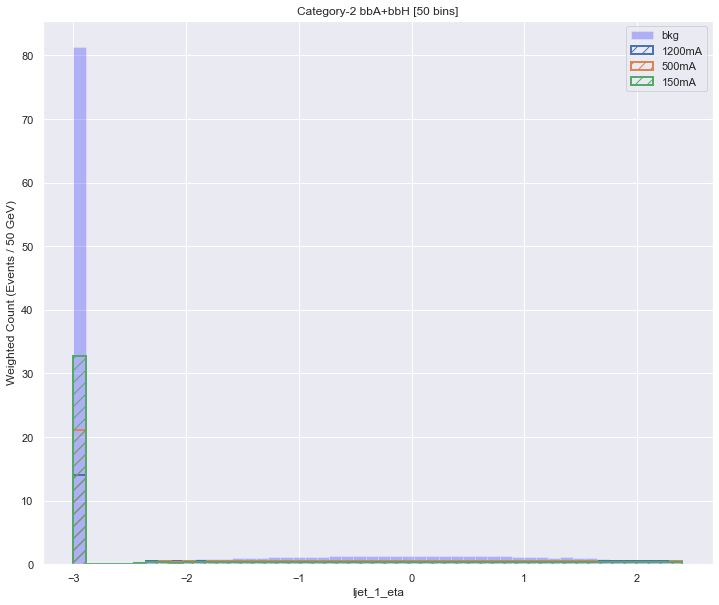

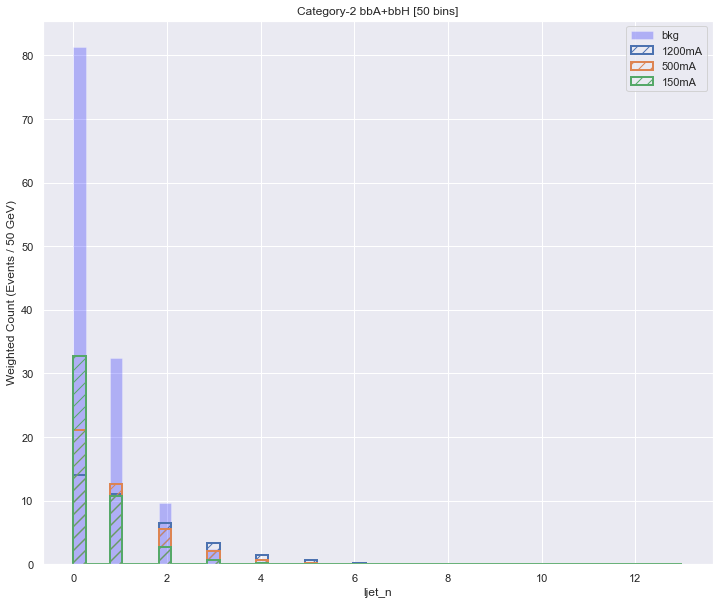

In [184]:
for var in VAR_CAT2:
    plot_var(data, variable=var, mass=[150, 500, 1200], limit=500.0, title='Category-2 bbA+bbH')

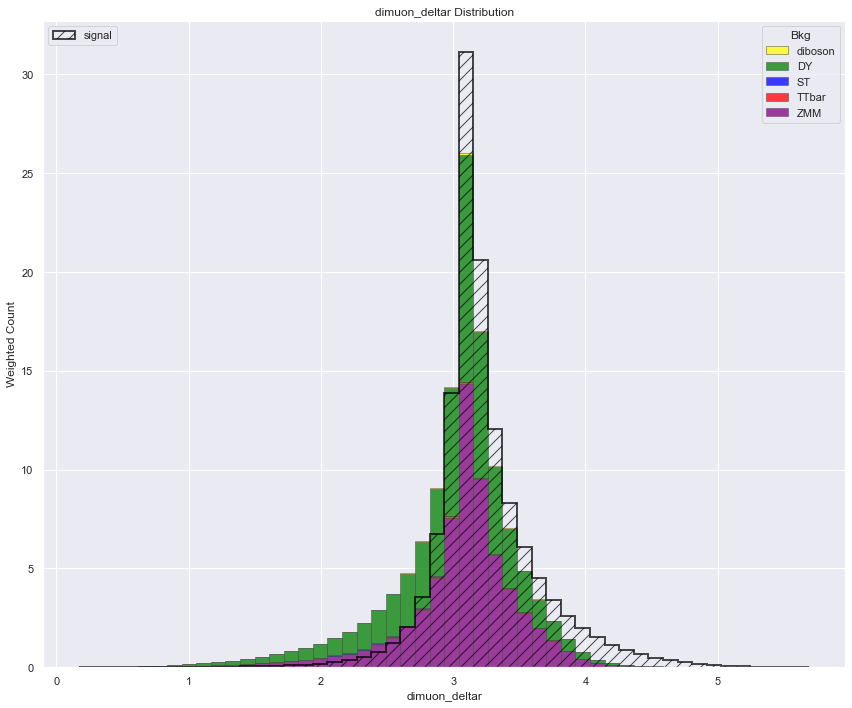

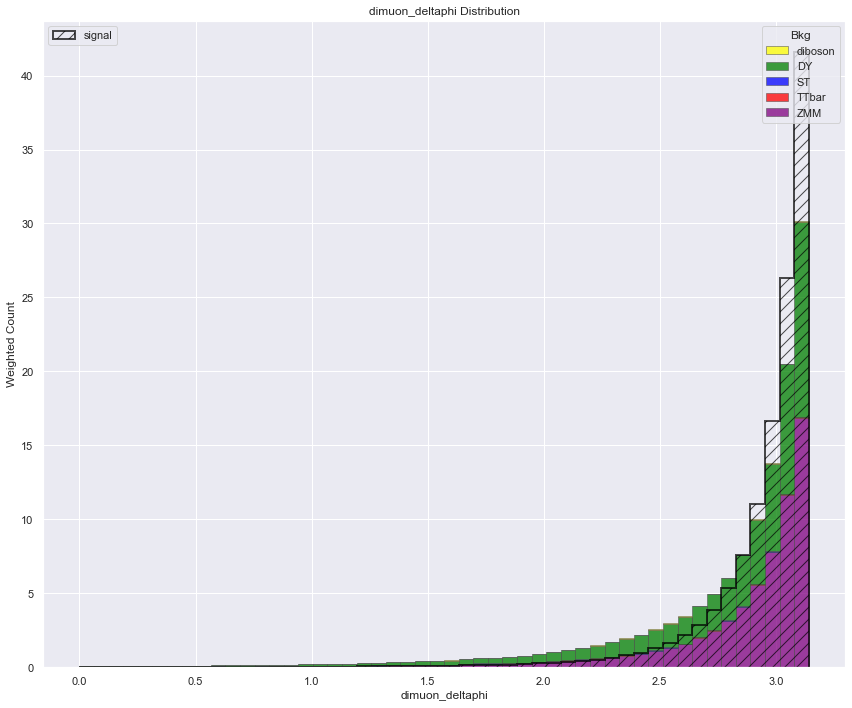

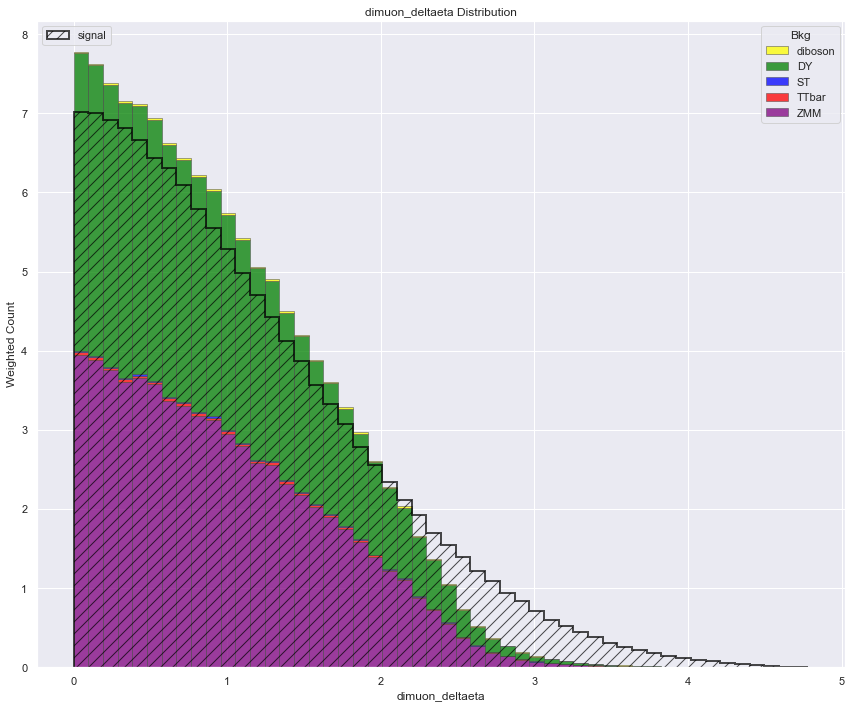

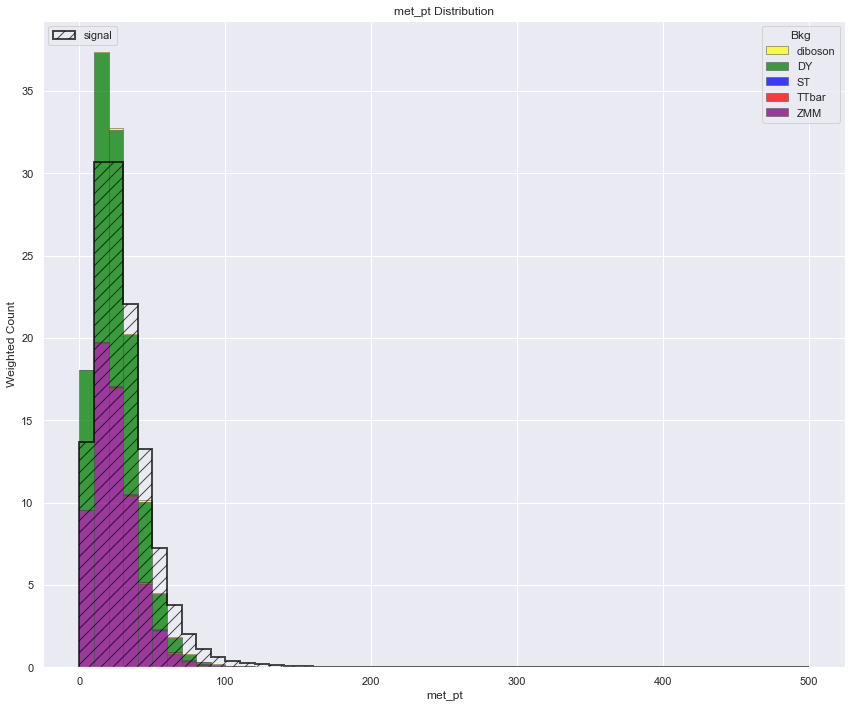

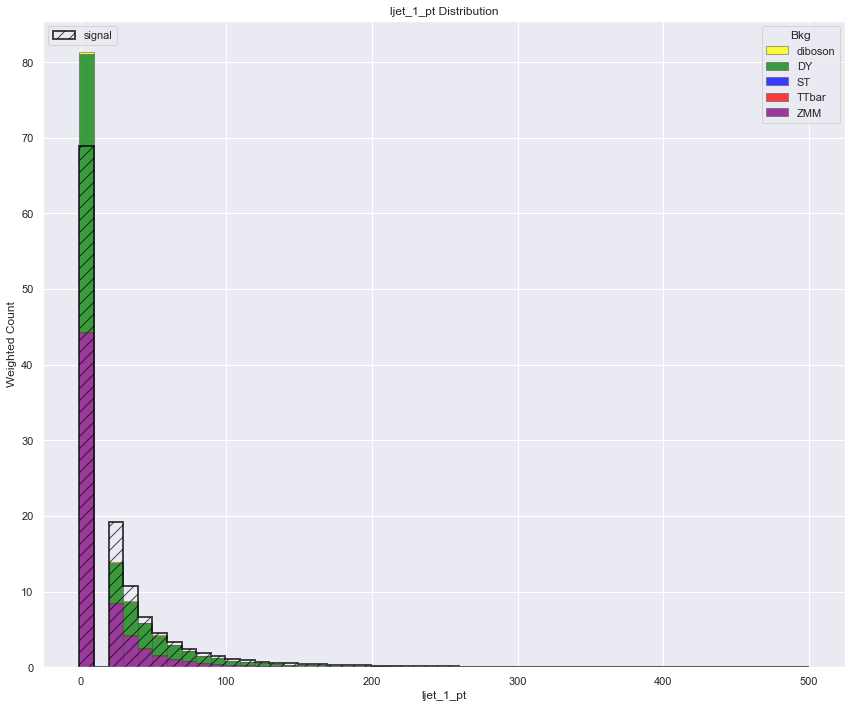

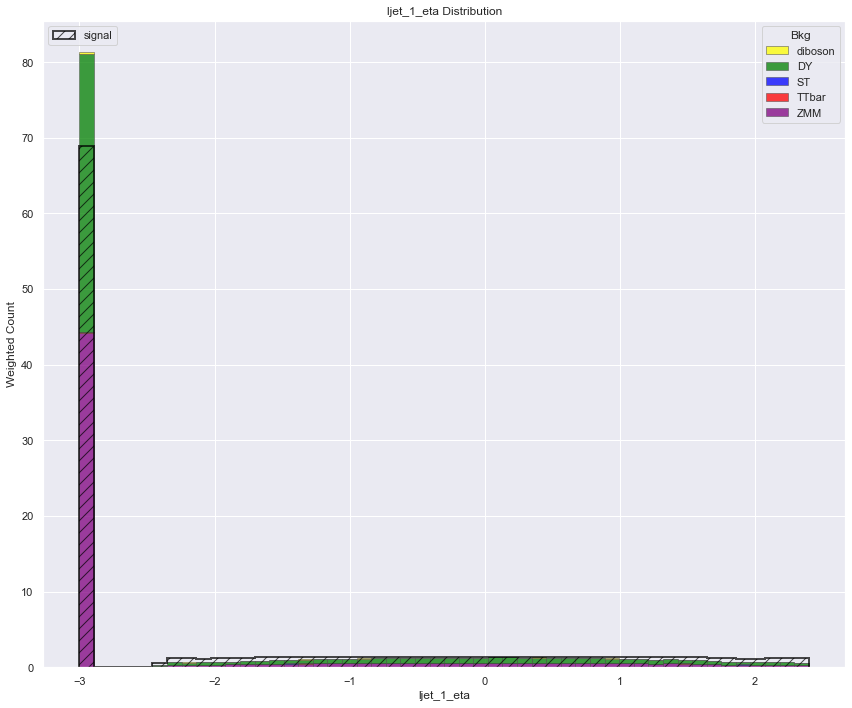

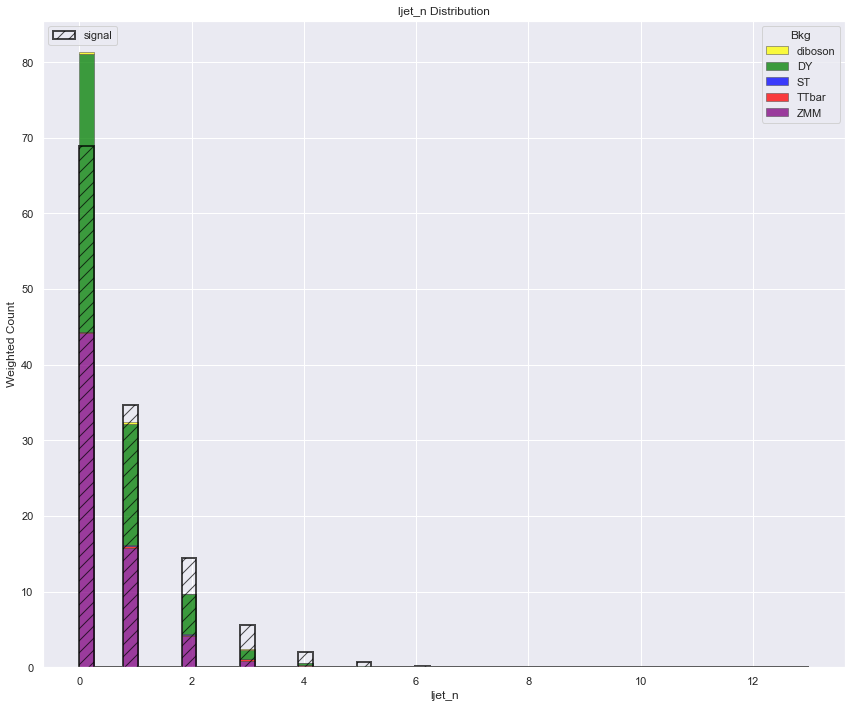

In [187]:
# variable plot on all data and mA
for var in VAR_CAT2:
    cms.plot.var(data, variable=var, bins=50, max_limit=500.0)

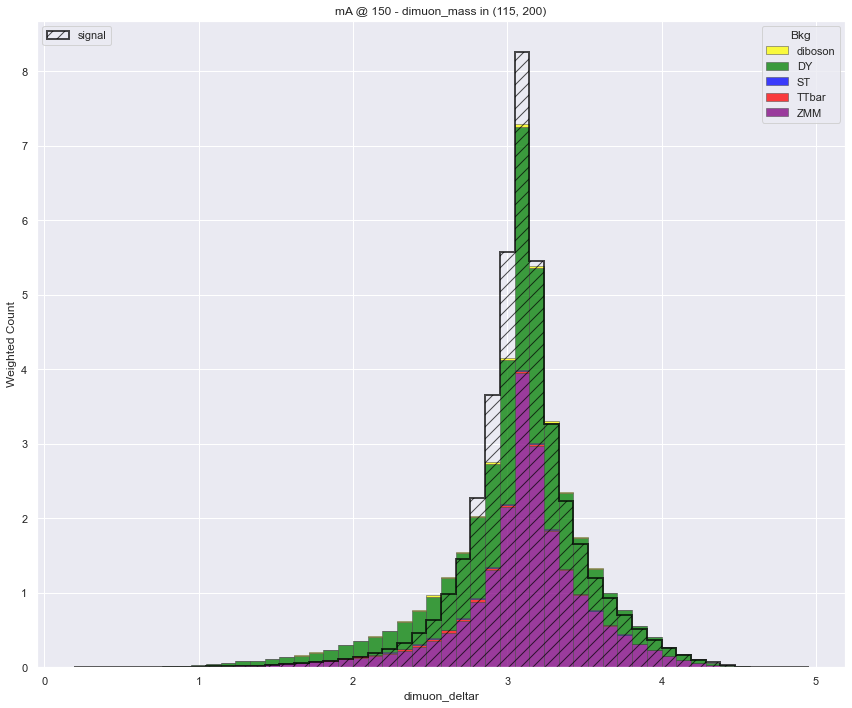

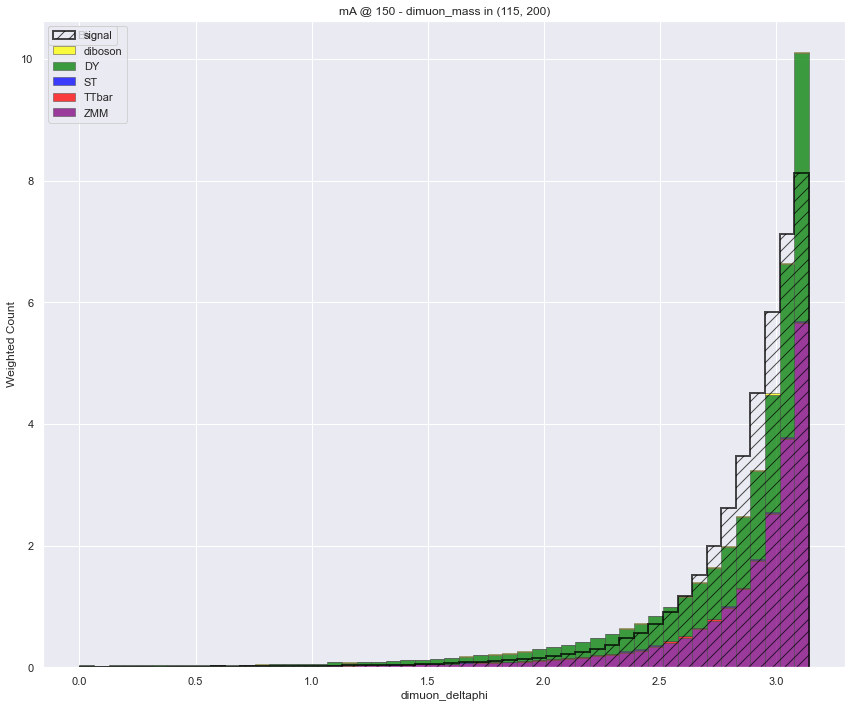

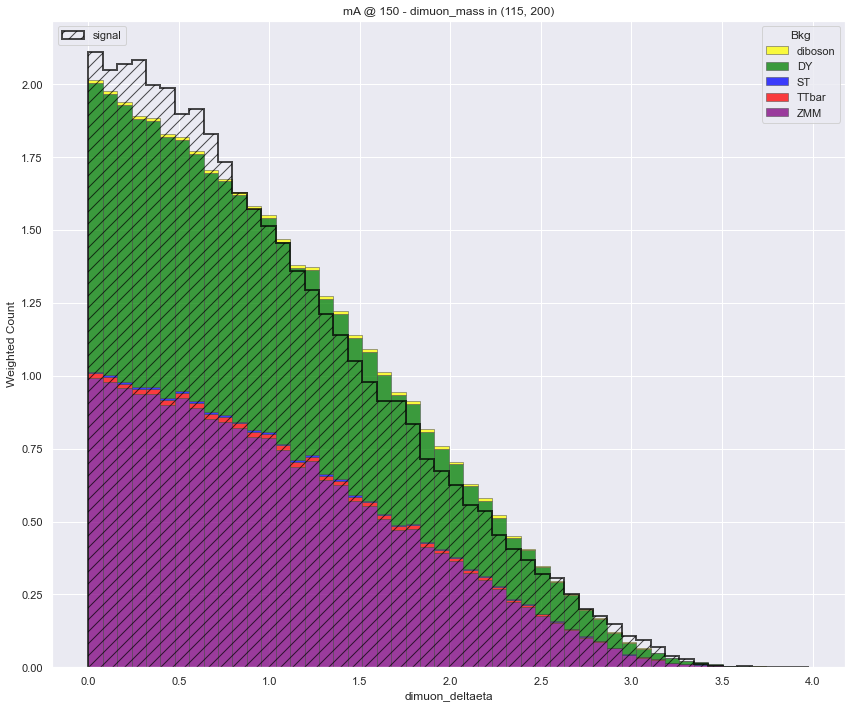

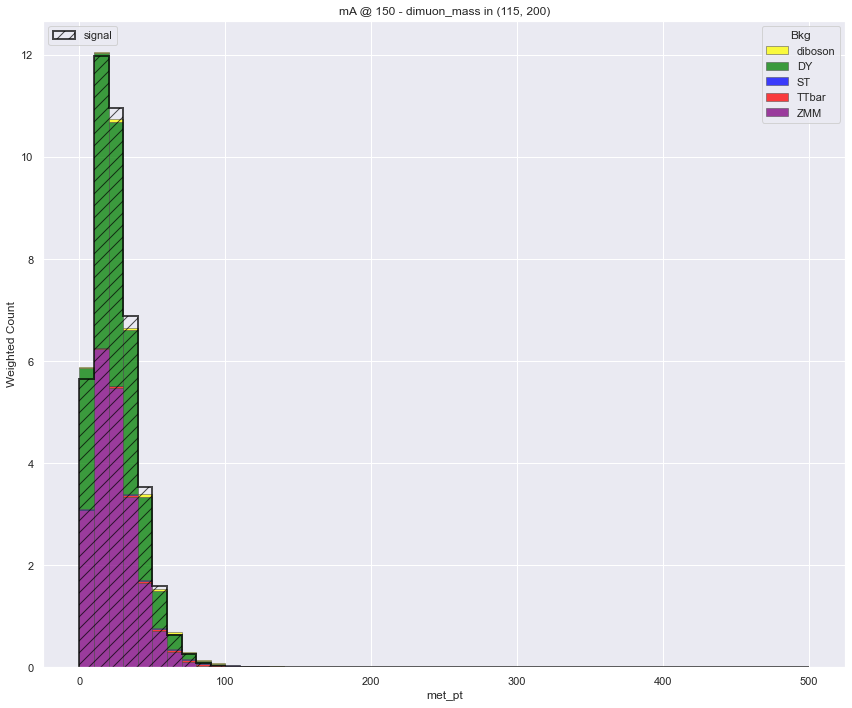

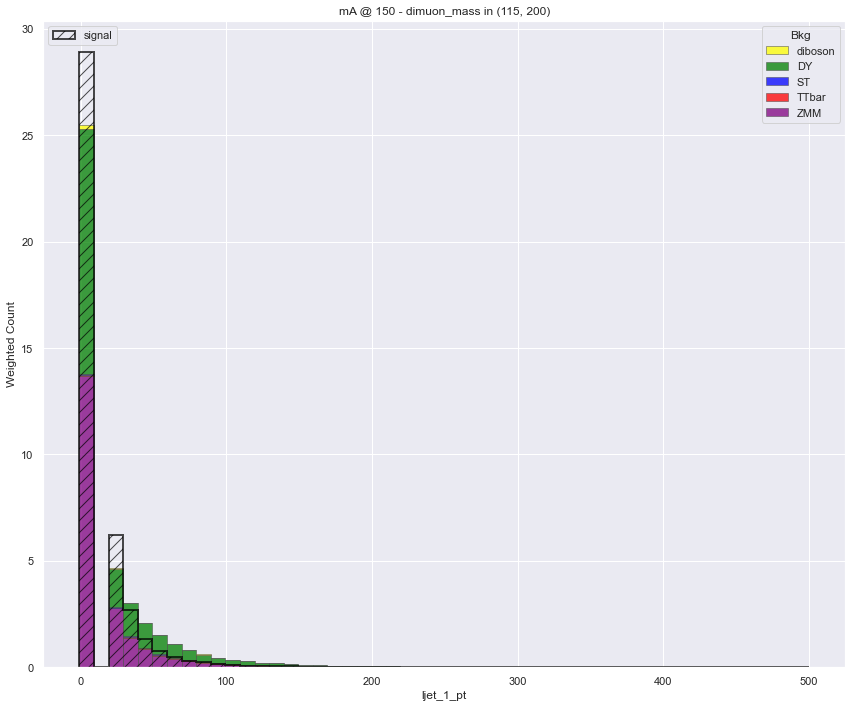

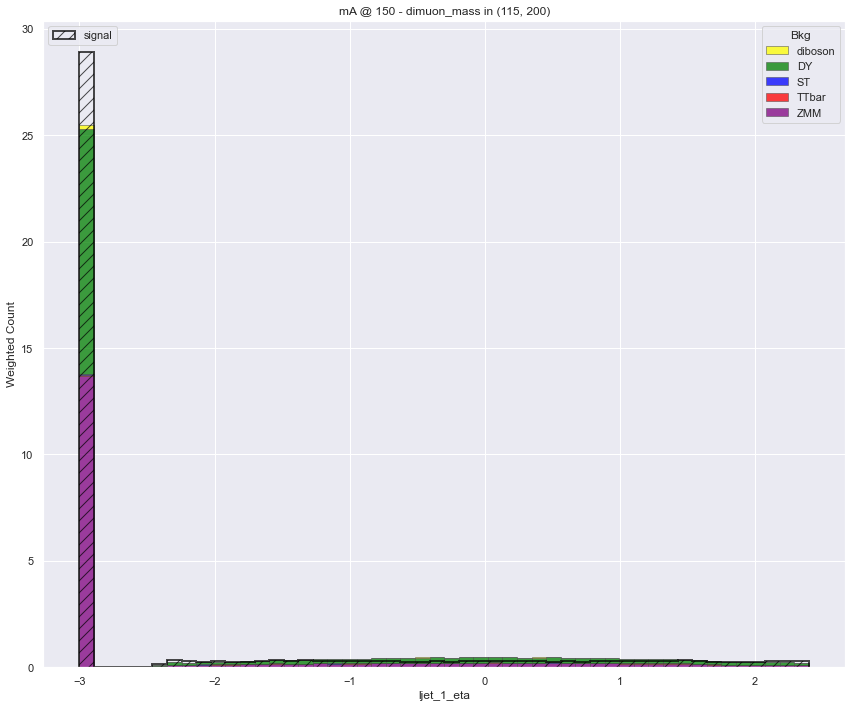

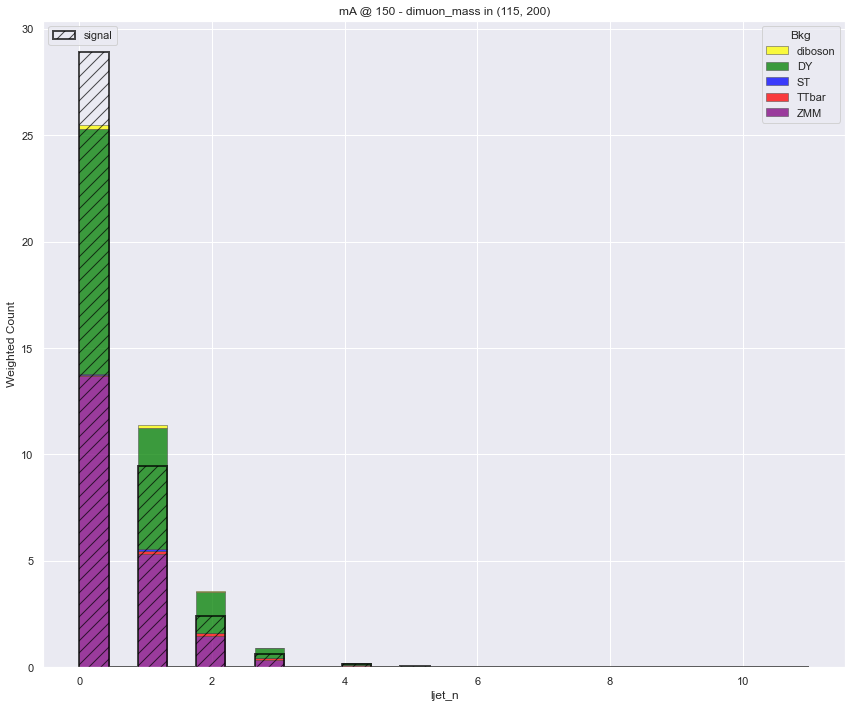

In [189]:
# input variables for a certain mA (and bkg in interval)
cms.plot.var_priori(data, variables=VAR_CAT2, mass=150, interval=INTERVALS[1], bins=50)

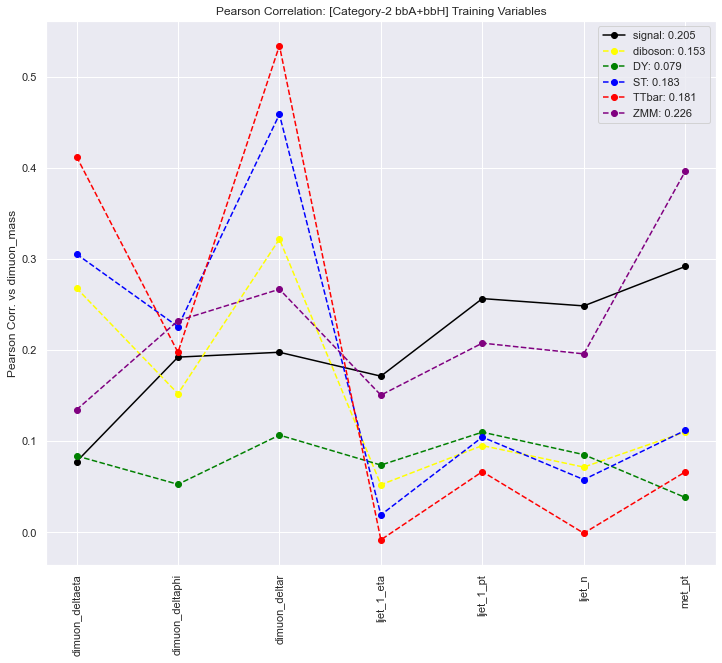

In [190]:
plot_corr(data, target='dimuon_mass', variables=VAR_CAT2, 
          title='[Category-2 bbA+bbH] Training Variables')

pNN-related plots:

In [13]:
mean = cms.retrieve_stat(cms.STATS_CAT1, which='mean', columns=VAR_CAT2)
std = cms.retrieve_stat(cms.STATS_CAT1, which='std', columns=VAR_CAT2)
clip = cms.retrieve_clip(cms.CLIP_CAT1, columns=VAR_CAT2)

preproc_layers = dict(x=[Clip(min_value=clip[:, 0], max_value=clip[:, 1]),
                         StandardScaler(mean=mean, std=std)],
                      m=[Divide(value=1000.0)])

In [14]:
model = utils.get_compiled_pnn(data, preprocess=preproc_layers, dropout=0.25)
utils.load_from_checkpoint(model, path='cat-2/pnn-preproc-drop-l2-new')

Loaded from "weights\cat-2/pnn-preproc-drop-l2-new\weights-17-0.685"


**bbA** (without `ZMM`):

In [15]:
bbA = cms.get_test_from_dataset(data, process='bbA')
bbA.mass_intervals = INTERVALS

[signal] loading...
[background] loading...
[Dataset] loaded.


In [16]:
CUT_CAT2_BBA_W = [0.43434343, 0.4040404 , 0.42424242, 0.38383838, 0.19191919,
                  0.39393939, 0.14141414, 0.14141414, 0.11111111, 0.1010101 ,
                  0.1010101 , 0.09090909, 0.04040404, 0.05050505, 0.04040404,
                  0.24242424]  # 100 bins

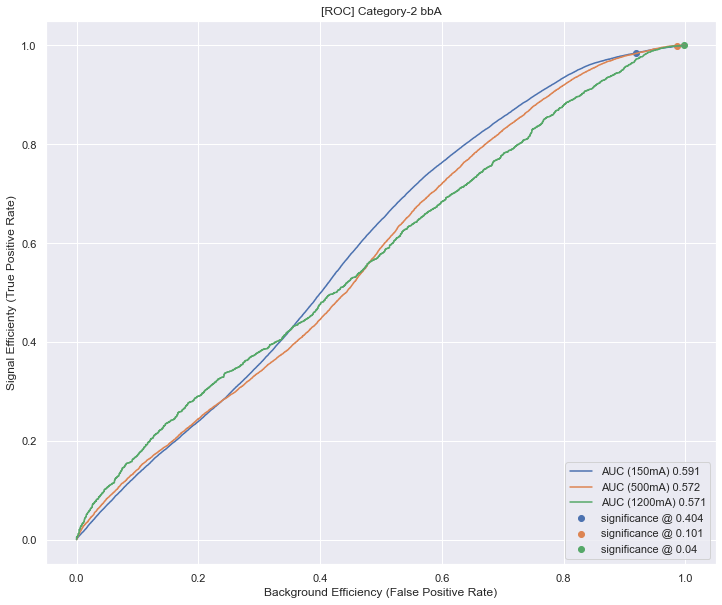

In [17]:
# ROC
fig = plt.figure(figsize=(12, 10))
ax = fig.gca()

cms.plot.compare_roc(bbA, models_and_cuts={'150mA': (model, CUT_CAT2_BBA_W[1])}, mass=150,
                     interval=INTERVALS[1], ax=ax, bins=100)

cms.plot.compare_roc(bbA, models_and_cuts={'500mA': (model, CUT_CAT2_BBA_W[9])}, mass=500,
                     interval=INTERVALS[9], ax=ax, bins=100)

cms.plot.compare_roc(bbA, models_and_cuts={'1200mA': (model, CUT_CAT2_BBA_W[-2])}, mass=1200,
                     interval=INTERVALS[-2], ax=ax, bins=100)

_ = ax.set_title('[ROC] Category-2 bbA')

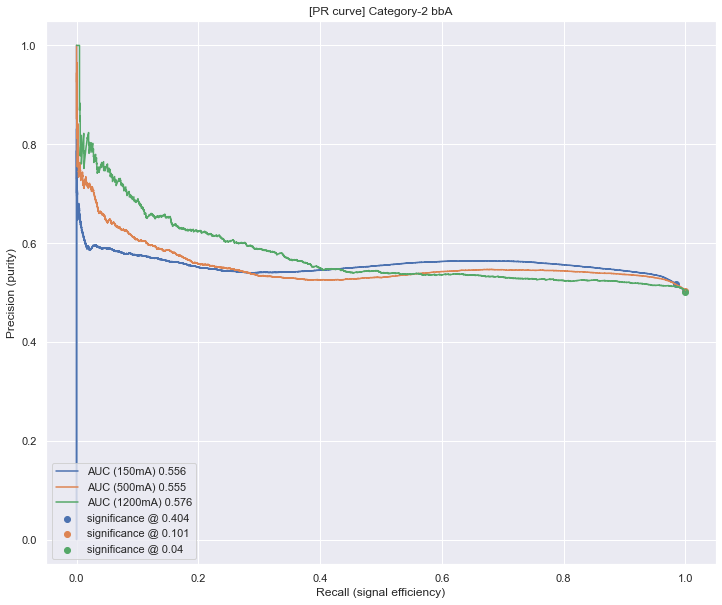

In [18]:
# PR
fig = plt.figure(figsize=(12, 10))
ax = fig.gca()

cms.plot.compare_pr(bbA, models_and_cuts={'150mA': (model, CUT_CAT2_BBA_W[1])}, mass=150,
                    interval=INTERVALS[1], ax=ax, bins=100)

cms.plot.compare_pr(bbA, models_and_cuts={'500mA': (model, CUT_CAT2_BBA_W[9])}, mass=500,
                    interval=INTERVALS[9], ax=ax, bins=100)

cms.plot.compare_pr(bbA, models_and_cuts={'1200mA': (model, CUT_CAT2_BBA_W[-2])}, mass=1200,
                    interval=INTERVALS[-2], ax=ax, bins=100)

_ = ax.set_title('[PR curve] Category-2 bbA')

**bbH** (without `ZMM`):

In [19]:
bbH = cms.get_test_from_dataset(data, process='bbH')
bbH.mass_intervals = INTERVALS

[signal] loading...
[background] loading...
[Dataset] loaded.


In [20]:
CUT_CAT2_BBH_W = [0.4040404 , 0.43434343, 0.09090909, 0.39393939, 0.15151515,
                  0.19191919, 0.13131313, 0.1010101 , 0.17171717, 0.11111111,
                  0.15151515, 0.09090909, 0.05050505, 0.05050505, 0.07070707,
                  0.21212121]  # 100 bins

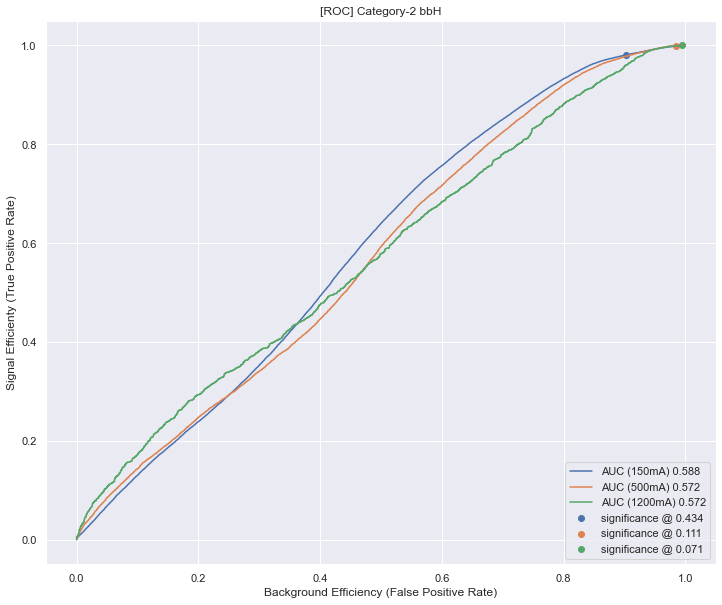

In [21]:
# ROC
fig = plt.figure(figsize=(12, 10))
ax = fig.gca()

cms.plot.compare_roc(bbH, models_and_cuts={'150mA': (model, CUT_CAT2_BBH_W[1])}, mass=150,
                     interval=INTERVALS[1], ax=ax, bins=100)

cms.plot.compare_roc(bbH, models_and_cuts={'500mA': (model, CUT_CAT2_BBH_W[9])}, mass=500,
                     interval=INTERVALS[9], ax=ax, bins=100)

cms.plot.compare_roc(bbH, models_and_cuts={'1200mA': (model, CUT_CAT2_BBH_W[-2])}, mass=1200,
                     interval=INTERVALS[-2], ax=ax, bins=100)

_ = ax.set_title('[ROC] Category-2 bbH')

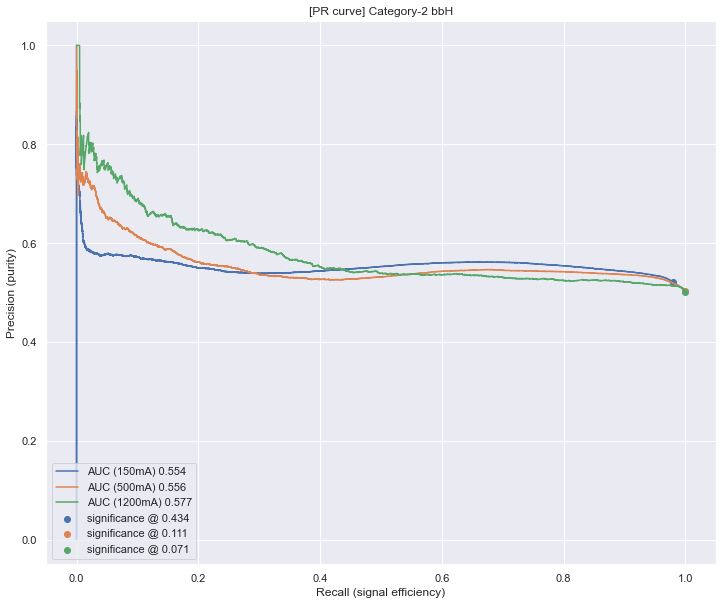

In [22]:
# PR
fig = plt.figure(figsize=(12, 10))
ax = fig.gca()

cms.plot.compare_pr(bbH, models_and_cuts={'150mA': (model, CUT_CAT2_BBH_W[1])}, mass=150,
                    interval=INTERVALS[1], ax=ax, bins=100)

cms.plot.compare_pr(bbH, models_and_cuts={'500mA': (model, CUT_CAT2_BBH_W[9])}, mass=500,
                    interval=INTERVALS[9], ax=ax, bins=100)

cms.plot.compare_pr(bbH, models_and_cuts={'1200mA': (model, CUT_CAT2_BBH_W[-2])}, mass=1200,
                    interval=INTERVALS[-2], ax=ax, bins=100)

_ = ax.set_title('[PR curve] Category-2 bbH')